In [2]:
from posebusters.posebusters import PoseBusters
from rdkit import Chem
import os
import pandas as pd
import re 
from typing import List

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Loading and processing results

### custom approaches to add

In [5]:
from Approach import DiffDockApproach, DiffDockPocketApproach, GninaApproach, SurfDockApproach, ICMApproach, ChaiApproach
exp_name = "plinder_set_0"
approaches = [
    DiffDockApproach(),
    DiffDockPocketApproach(),
    GninaApproach(),
    SurfDockApproach(),
    ICMApproach(),
    ChaiApproach(),
]
df_all = []
for approach in approaches:
    method_name = approach.get_name()
    print(method_name)
    df_method  = pd.read_csv(f"{method_name}_{exp_name}_results.csv")
    print(df_method.shape)
    df_all.append(df_method)

df_combined = pd.concat(df_all, ignore_index=True)

diffdock
(3575, 129)
diffdock_pocket_only
(4660, 130)
gnina
(5160, 130)
surfdock
(4216, 130)
icm
(5050, 129)
chai-1
(4580, 130)


/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_88138/3883161924.py:15: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df_method  = pd.read_csv(f"{method_name}_{exp_name}_results.csv")
/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_88138/3883161924.py:15: DtypeWarning: Columns (6,7,8,9,32,33,34,35,36,37,38,39,40,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df_method  = pd.read_csv(f"{method_name}_{exp_name}_results.csv")


In [6]:
len(df_combined[df_combined.method == 'surfdock']['protein'].unique())

681

### remove covalent, cofactor, and ionic systems

In [7]:
df_combined = pd.read_csv(f"./plinder_test_combined.csv")
print(df_combined.shape)

# build a boolean mask: drop any row where covalent, ionic or has_ion is True
mask = ~(
    df_combined['ligand_is_covalent'] |
    df_combined['ligand_is_ion'] |
    df_combined['has_ion'] |
    df_combined['ligand_is_cofactor']
)
# number of rows and systems flagged
n_rows = mask.sum()
print(f"Flagged rows: {n_rows}")
n_systems = df_combined.loc[mask, 'system_id'].nunique()
print(f"Unique systems flagged: {n_systems}")

# count unique systems in each of the four categories
for col in ['ligand_is_covalent', 'ligand_is_ion', 'has_ion', 'ligand_is_cofactor']:
    n_sys = df_combined.loc[df_combined[col], 'system_id'].nunique()
    print(f"{col}: {n_sys} unique systems")

# count by kept vs dropped
kept = df_combined.loc[mask, 'system_id'].nunique()
dropped = df_combined.loc[~mask, 'system_id'].nunique()
print(f"Kept systems (none of the 4 flags): {kept}")
print(f"Dropped systems (any flag): {dropped}")

# filter and reset index
df_combined = df_combined.loc[mask].reset_index(drop=True)
print("Filtered shape:", df_combined.shape)


(26836, 154)
Flagged rows: 13175
Unique systems flagged: 482
ligand_is_covalent: 198 unique systems
ligand_is_ion: 0 unique systems
has_ion: 280 unique systems
ligand_is_cofactor: 137 unique systems
Kept systems (none of the 4 flags): 482
Dropped systems (any flag): 538
Filtered shape: (13175, 154)


/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_88138/2298163297.py:1: DtypeWarning: Columns (75,129) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv(f"./plinder_test_combined.csv")


# Overall Analysis

### Basic sumaries and Distributions 

In [8]:
df_combined['rmsd_≤_1å'] = df_combined['rmsd'] <=1 
df_combined['rmsd_≤_5å'] = df_combined['rmsd'] <=5

df_combined["method"].value_counts()

method
gnina                   2410
icm                     2365
chai-1                  2265
diffdock_pocket_only    2255
surfdock                2040
diffdock                1840
Name: count, dtype: int64

In [9]:
# Get proteins present in ICM method
icm_proteins = df_combined[df_combined['method'] == 'icm']['protein'].unique()
# Filter vina data to keep only proteins that exist in ICM
df_combined_filtered = df_combined[
      (df_combined['protein'].isin(icm_proteins))]


# # Filter gnina data to keep only proteins that exist in ICM
# df_combined_filtered = df_combined[
#     ~((df_combined['method'] == 'gnina') & 
#       (~df_combined['protein'].isin(icm_proteins)))
# ]

# df_combined = df_combined_filtered
# print(df_combined['method'].value_counts())

# # Filter vina data to keep only proteins that exist in ICM
# df_combined_filtered = df_combined[
#     ~((df_combined['method'] == 'vina') & 
#       (~df_combined['protein'].isin(icm_proteins)))
# ]

# # Filter vina data to keep only proteins that exist in ICM
# df_combined_filtered = df_combined[
#     ~((df_combined['method'] == 'surfdock') & 
#       (~df_combined['protein'].isin(icm_proteins)))
# ]


df_combined = df_combined_filtered
print(df_combined['method'].value_counts())

method
gnina                   2365
icm                     2365
diffdock_pocket_only    2220
chai-1                  2220
surfdock                2025
diffdock                1815
Name: count, dtype: int64


In [10]:
df_combined.groupby("method")['method'].value_counts()

method
chai-1                  2220
diffdock                1815
diffdock_pocket_only    2220
gnina                   2365
icm                     2365
surfdock                2025
Name: count, dtype: int64

In [11]:
df_combined.groupby("method")["rmsd_≤_2å"].mean()

method
chai-1                  0.381081
diffdock                0.511846
diffdock_pocket_only    0.504054
gnina                   0.331078
icm                     0.266385
surfdock                0.675556
Name: rmsd_≤_2å, dtype: float64

In [12]:
df_combined.groupby("method")["rmsd_≤_2å"].value_counts()

method                rmsd_≤_2å
chai-1                False        1374
                      True          846
diffdock              True          929
                      False         886
diffdock_pocket_only  True         1119
                      False        1101
gnina                 False        1582
                      True          783
icm                   False        1735
                      True          630
surfdock              True         1368
                      False         657
Name: count, dtype: int64

In [13]:
df_combined.groupby("method")["rmsd"].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
chai-1,2216.0,9.715477,11.521842,0.154861,1.110494,3.826017,17.590152,54.564423
diffdock,1815.0,7.982091,11.142850,0.121857,0.795297,1.915252,10.077452,55.732265
diffdock_pocket_only,2220.0,7.118845,9.680867,0.174323,0.819205,1.906383,8.580197,42.554162
gnina,2365.0,3.415366,2.432284,0.087559,1.698013,2.772162,4.725801,16.172347
icm,2355.0,4.198048,2.946953,0.156208,1.920913,3.475187,6.012130,18.352233
surfdock,2025.0,2.160065,2.249267,0.153307,0.700093,1.203508,2.695932,13.701280


In [14]:
df_combined.to_csv(f"{exp_name}_results_filtered.csv", index=False)

**Top-1 overlapped proteins with diffdock**

In [15]:
common_proteins = df_combined.loc[df_combined["method"] == "diffdock", "protein"].unique()
df_icm_for_same_proteins = df_combined.loc[
    (df_combined["method"] == "icm") &
    (df_combined["protein"].isin(common_proteins))
]
df_icm_for_same_proteins['rmsd_≤_2å'].value_counts()
df_icm_for_same_proteins_top1 = df_icm_for_same_proteins.loc[
    df_icm_for_same_proteins.groupby("protein")["score"].idxmin()
]
df_icm_for_same_proteins_top1['rmsd_≤_2å'].value_counts()

rmsd_≤_2å
True     227
False    136
Name: count, dtype: int64

### Histograms and densities

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_88138/1941873662.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_combined, x="rmsd", hue="method", shade=True)


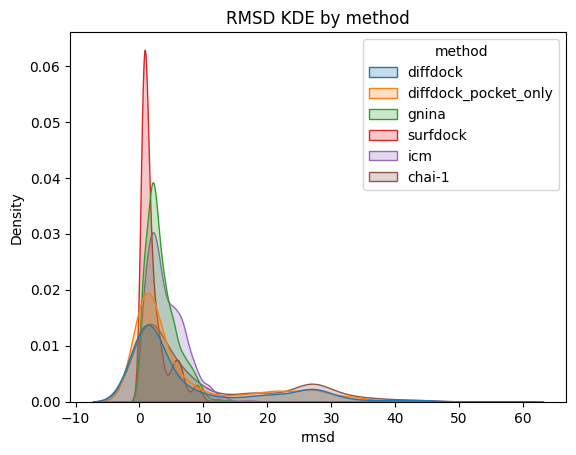

In [16]:
sns.kdeplot(data=df_combined, x="rmsd", hue="method", shade=True)
plt.title("RMSD KDE by method")
plt.show()

### absolute number of successful predictions 

In [17]:
df_combined["success"] = df_combined["rmsd_≤_2å"]
# For each protein, count how many methods succeeded
success_counts = (
    df_combined[df_combined["success"] == True]
    .groupby(["protein","method"])["success"]
    .first()  # or .any(), if multiple rows
    .unstack(fill_value=False)
)

### absolute number of systems with at least one successful prediction

In [70]:
# For method="icm"
print("\nAbsolute successes per method:")
for method in df_combined["method"].unique():
    method_df = df_combined[df_combined["method"] == method]
    method_success_count = success_counts[method].sum()  # Count True values
    total_proteins = method_df["protein"].nunique()  # Count unique proteins
    print(f"{method}: {method_success_count / total_proteins:.2f}, {method_success_count} successes out of {total_proteins} proteins")


Absolute successes per method:
diffdock: 0.58, 211 successes out of 363 proteins
diffdock_pocket_only: 0.57, 253 successes out of 444 proteins
gnina: 0.86, 407 successes out of 473 proteins
surfdock: 0.83, 265 successes out of 318 proteins
icm: 0.81, 382 successes out of 473 proteins
chai-1: 0.47, 209 successes out of 444 proteins


## Histogram for 1å, 2å, and 5å

#### mean RMSD by method
mean_rmsd = df_combined.groupby('method')['rmsd'].mean().reset_index()

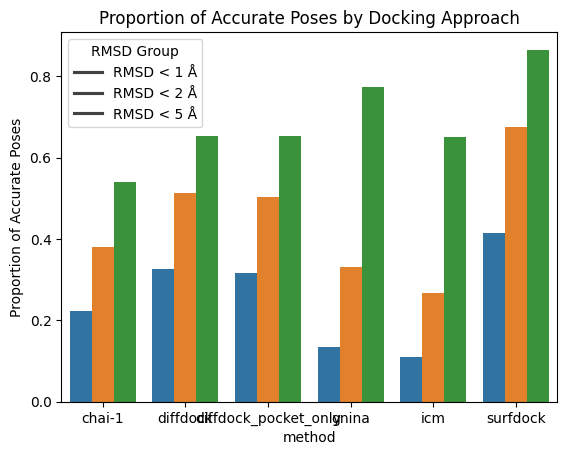

In [19]:
# Proportion of accurate poses
melted = df_combined.melt(id_vars='method', 
                        value_vars=['rmsd_≤_1å', 'rmsd_≤_2å', 'rmsd_≤_5å'],
                        var_name='RMSD_Group',
                        value_name='Is_Accurate')

prop = melted.groupby(['method', 'RMSD_Group'])['Is_Accurate'].mean().reset_index()

sns.barplot(data=prop, x='method', y='Is_Accurate', hue='RMSD_Group')
plt.ylabel('Proportion of Accurate Poses')
plt.title('Proportion of Accurate Poses by Docking Approach')
plt.legend(title='RMSD Group', labels=['RMSD < 1 Å', 'RMSD < 2 Å', 'RMSD < 5 Å'])
plt.show()


#### Top-5 RMSD 

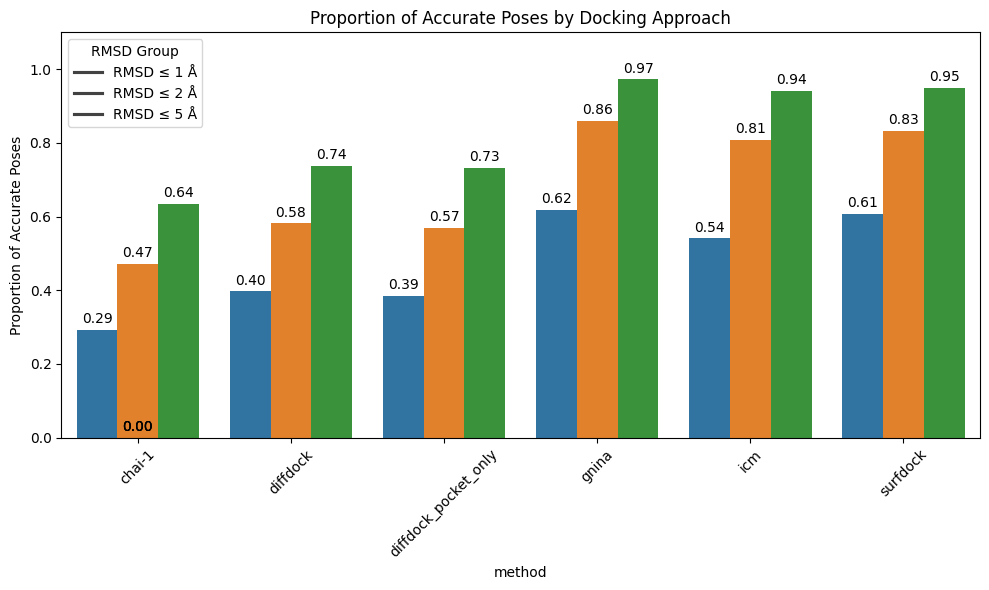

In [50]:
# Create success columns for each RMSD threshold
df_combined['success_1å'] = df_combined['rmsd_≤_1å']
df_combined['success_2å'] = df_combined['rmsd_≤_2å']
df_combined['success_5å'] = df_combined['rmsd_≤_5å']

# Group by protein and method, and check if any conformer satisfies each threshold
success_agg = df_combined.groupby(['protein', 'method']).agg({
    'success_1å': 'max',
    'success_2å': 'max',
    'success_5å': 'max'
}).reset_index()

# Melt the aggregated DataFrame for plotting
melted_success = success_agg.melt(
    id_vars=['protein', 'method'],
    value_vars=['success_1å', 'success_2å', 'success_5å'],
    var_name='RMSD_Group',
    value_name='Is_Accurate'
)

# Calculate the proportion of accurate poses
prop_success = melted_success.groupby(['method', 'RMSD_Group'])['Is_Accurate'].mean().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=prop_success,
    x='method',
    y='Is_Accurate',
    hue='RMSD_Group'
)

# annotate each bar with its height (proportion)
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.01,
        f"{height:.2f}",
        ha='center',
        va='bottom'
    )

plt.ylabel('Proportion of Accurate Poses')
plt.title('Proportion of Accurate Poses by Docking Approach')
plt.legend(
    title='RMSD Group',
    labels=['RMSD ≤ 1 Å', 'RMSD ≤ 2 Å', 'RMSD ≤ 5 Å']
)
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

### Cumulative Plots for the RMSD

In [64]:
# Group by method and example, and compute the minimum RMSD among the multiple conformations
df_min_rmsd = (
    df_combined
    .groupby(["method", "protein"], as_index=False)["rmsd"]
    .min()
    .rename(columns={"rmsd": "min_rmsd"})
)

# plt.figure(figsize=(8, 6))

# # Plot the ECDF for min_rmsd by method, capturing the Axes object
# ax = sns.ecdfplot(
#     data=df_min_rmsd,
#     x="min_rmsd",
#     hue="method"
# )

# plt.xlabel("Minimum RMSD (Å) per Example")
# plt.xlim(0, 10)
# plt.ylabel("Proportion of Examples with RMSD ≤ x")
# plt.title("Cumulative Distribution of Minimum RMSD by Method")

# # Manually fetch the handles and labels from the Axes
# handles, labels = ax.get_legend_handles_labels()

# # Then create the legend manually
# plt.legend(handles, labels, title="Method", loc="best")

# plt.show()

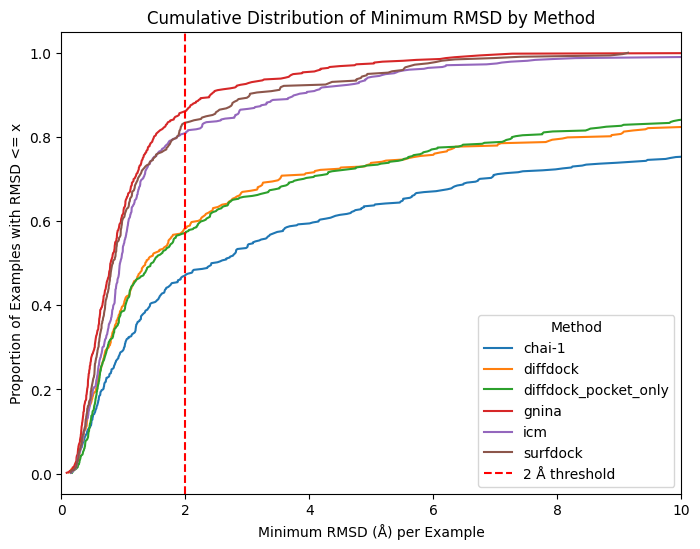

In [65]:
# Identify the unique docking methods
methods = df_min_rmsd["method"].unique()
plt.figure(figsize=(8, 6))

for m in methods:
    # Filter the data for this method
    subset = df_min_rmsd[df_min_rmsd["method"] == m]["min_rmsd"].values
    # Sort min_rmsd
    sorted_vals = np.sort(subset)
    # Compute the empirical CDF
    yvals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    # Plot the curve
    plt.plot(sorted_vals, yvals, label=m)

plt.axvline(x=2, color='red', linestyle='--', label='2 Å threshold')
plt.xlabel("Minimum RMSD (Å) per Example")
plt.xlim(0, 10)
plt.ylabel("Proportion of Examples with RMSD <= x")
plt.title("Cumulative Distribution of Minimum RMSD by Method")
plt.legend(title="Method", loc="best")
plt.show()

### Rank-1 Statistics

In [71]:
for method in ["icm", "diffdock_pocket_only", "chai-1", "surfdock", "gnina"]:
    tmp = df_combined.loc[df_combined['method']== method]
    tmp = tmp.loc[tmp['rank'] == 1]
    print(tmp['success'].value_counts())

success
True     285
False    188
Name: count, dtype: int64
success
True     227
False    217
Name: count, dtype: int64
success
False    270
True     174
Name: count, dtype: int64
success
True     294
False    111
Name: count, dtype: int64
success
True     328
False    145
Name: count, dtype: int64


In [72]:
top1 = df_combined[df_combined["rank"] == 1] \
           .drop_duplicates(subset=["protein","method"])
pivot_df = top1.pivot(
    index="protein",
    columns="method",
    values="rmsd"
)

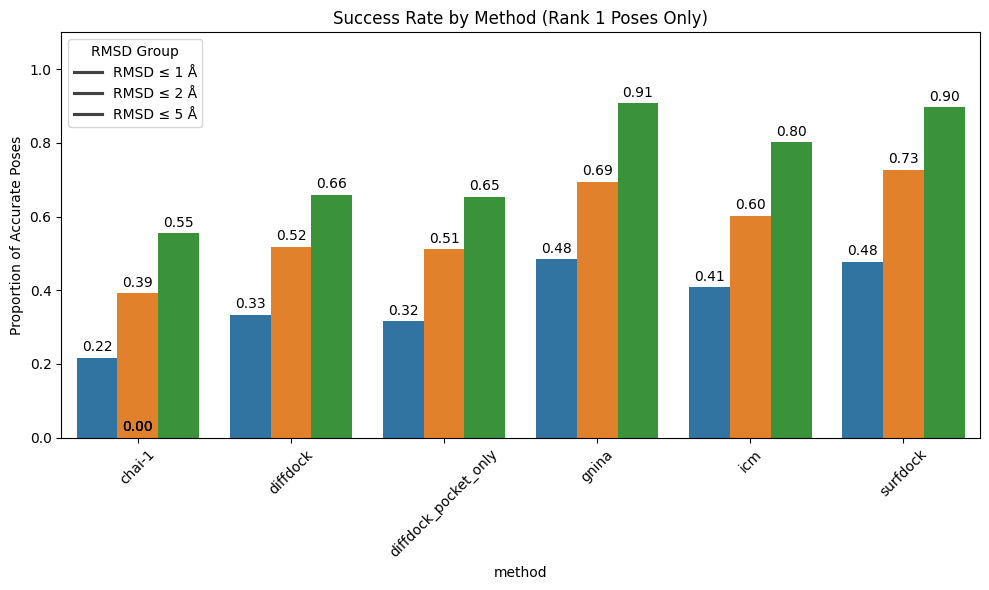

In [73]:
# Filter for rank 1 results
rank1_df = df_combined[df_combined['rank'] == 1]

# Calculate success rates for different thresholds
melted = rank1_df.melt(id_vars='method', 
                       value_vars=['rmsd_≤_1å', 'rmsd_≤_2å', 'rmsd_≤_5å'],
                       var_name='RMSD_Group',
                       value_name='Is_Accurate')

# Calculate proportion for each method and threshold
prop = melted.groupby(['method', 'RMSD_Group'])['Is_Accurate'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=prop, x='method', y='Is_Accurate', hue='RMSD_Group')

# Add text annotations for each bar showing the proportion values
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.01,
        f"{height:.2f}",
        ha='center',
        va='bottom'
    )

plt.ylabel('Proportion of Accurate Poses')
plt.title('Success Rate by Method (Rank 1 Poses Only)')
plt.legend(title='RMSD Group', labels=['RMSD ≤ 1 Å', 'RMSD ≤ 2 Å', 'RMSD ≤ 5 Å'])
plt.xticks(rotation=45)
plt.ylim(0, 1.1)  # Set y-limit to ensure annotations are visible
plt.tight_layout()
plt.show()

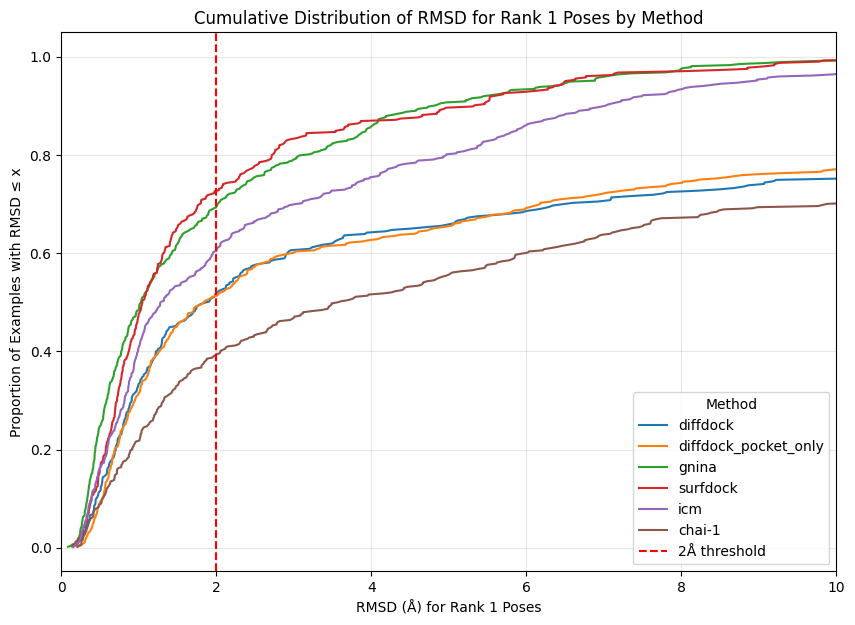

In [69]:
# Filter for rank 1 results only
rank1_df = df_combined[df_combined['rank'] == 1]

# Identify the unique docking methods
methods = rank1_df["method"].unique()
plt.figure(figsize=(10, 7))

for m in methods:
    # Filter the data for this method
    subset = rank1_df[rank1_df["method"] == m]["rmsd"].values
    # Sort RMSD values
    sorted_vals = np.sort(subset)
    # Compute the empirical CDF
    yvals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    # Plot the curve
    plt.plot(sorted_vals, yvals, label=m)

# Add horizontal line at RMSD = 2Å
plt.axvline(x=2, color='red', linestyle='--', label='2Å threshold')

plt.xlabel("RMSD (Å) for Rank 1 Poses")
plt.xlim(0, 10)
plt.ylabel("Proportion of Examples with RMSD ≤ x")
plt.title("Cumulative Distribution of RMSD for Rank 1 Poses by Method")
plt.legend(title="Method", loc="best")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
df_combined['rmsd'] = np.log1p(df_combined['rmsd'])

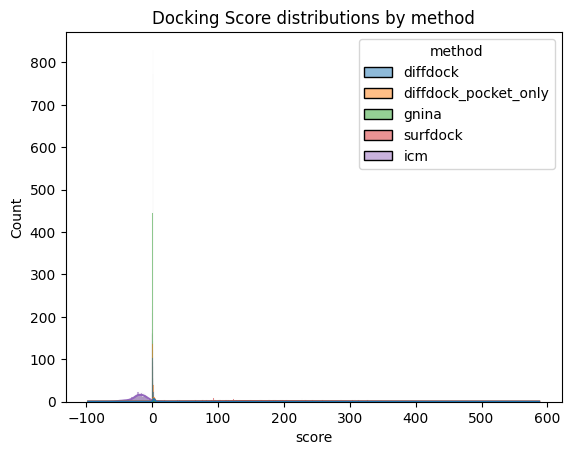

In [23]:
sns.histplot(data=df_combined.dropna(subset=["score"]), x="score", hue="method", kde=True)
plt.title("Docking Score distributions by method")
plt.show()

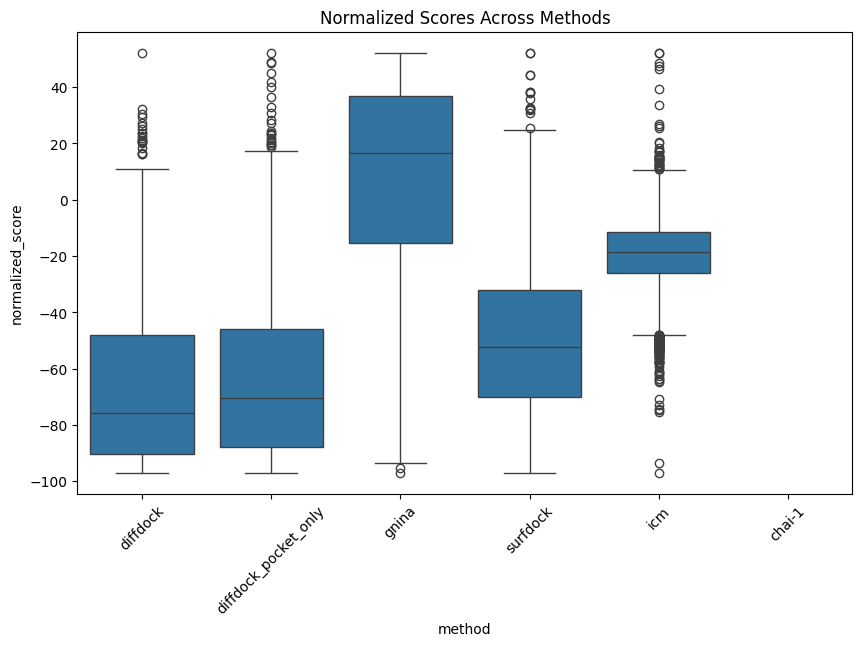

In [24]:
# Get ICM score range for scaling reference
icm_min = df_combined[df_combined['method'] == 'icm']['score'].min()
icm_max = df_combined[df_combined['method'] == 'icm']['score'].max()

# Create normalized scores column
def normalize_to_icm_scale(group):
    method = group['method'].iloc[0]
    if method == 'icm':
        return group['score']
    else:
        # Min-max normalization scaled to ICM range
        method_min = group['score'].min()
        method_max = group['score'].max()
        return (group['score'] - method_min) * (icm_max - icm_min) / (method_max - method_min) + icm_min

# Apply normalization
df_combined['normalized_score'] = df_combined.groupby('method').apply(normalize_to_icm_scale).reset_index(level=0, drop=True)

# Plot comparison
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='method', y='normalized_score')
plt.title('Normalized Scores Across Methods')
plt.xticks(rotation=45)
plt.show()

**Confidence/Score histograms**

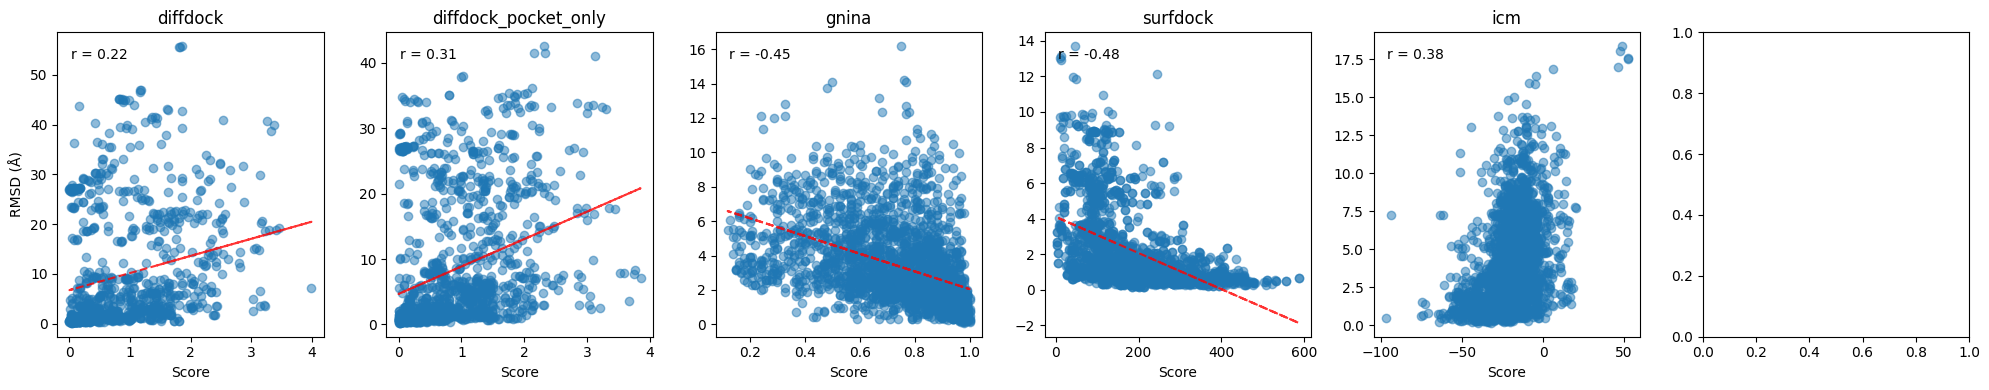

In [25]:
# Create a figure with subplots for each method
methods = df_combined['method'].unique()
n_methods = len(methods)
fig, axes = plt.subplots(1, n_methods, figsize=(20, 4))

for idx, method in enumerate(methods):
    if method == 'chai-1':
        continue
    method_data = df_combined[df_combined['method'] == method].dropna(subset=['score'])
    
    # Create scatter plot
    axes[idx].scatter(method_data['score'], method_data['rmsd'], alpha=0.5)
    
    # Add regression line
    z = np.polyfit(method_data['score'], method_data['rmsd'], 1)
    p = np.poly1d(z)
    axes[idx].plot(method_data['score'], p(method_data['score']), "r--", alpha=0.8)
    
    # Customize subplot
    axes[idx].set_title(f'{method}')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('RMSD (Å)' if idx == 0 else '')
    
    # Add correlation coefficient
    corr = method_data['score'].corr(method_data['rmsd'])
    axes[idx].text(0.05, 0.95, f'r = {corr:.2f}', 
                  transform=axes[idx].transAxes, 
                  verticalalignment='top')

plt.tight_layout()
plt.show()

In [26]:
methods = df_combined.dropna(subset=["score"])["method"].unique()

for m in methods:
    subset = df_combined[(df_combined["method"] == m) & (df_combined["score"].notna())]
    fig = px.scatter(
        subset,
        x="score",
        y="rmsd",
        color="rmsd_≤_2å",
        title=f"RMSD vs Score for {m}",
        width=800,
        height=600
    )
    fig.show()

### Statistical analysis for RMSD and score 

In [27]:
from scipy.stats import pearsonr, spearmanr
for method in df_combined['method'].unique():
    if method == 'chai-1':
        continue
    for group in 'rmsd_≤_1å', 'rmsd_≤_2å', 'rmsd_≤_5å':
        subset = df_combined[(df_combined['method'] == method) & (df_combined[group])]
        # Filter out NaN/Inf values before correlation
        subset_clean = subset.dropna(subset=['score', 'rmsd'])
        subset_clean = subset_clean[~subset_clean.isin([np.inf, -np.inf]).any(axis=1)]
        # print(f"{method} {group} accuracy: {df_combined[(df_combined['method']==method.mean())]:.3f}")
        # corr = subset_clean['rmsd'].corr(subset_clean['score'])
        pearson_corr, pearson_p = pearsonr(subset_clean['score'], subset_clean['rmsd'])
        spearman_corr, spearman_p = spearmanr(subset_clean['score'], subset_clean['rmsd'])

        print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")
        print(f"Spearman Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")
        # print(f"{method} correlation for {group}: {corr:.3f}")

        # Scatter Plots
        # sns.scatterplot(x='rmsd', y='score', hue='method', data=subset)
        # plt.title('RMSD vs. Score by Docking Method')
        # plt.show()

        # linear regreesion 
    subset = (df_combined[(df_combined['method']==method)])
    subset = subset.dropna(subset=['score', 'rmsd'])
    subset = subset[~subset.isin([np.inf, -np.inf]).any(axis=1)]    
    corr = subset['rmsd'].corr(subset['score'])
    pearson_corr, pearson_p = pearsonr(subset['score'], subset['rmsd'])
    spearman_corr, spearman_p = spearmanr(subset['score'], subset['rmsd'])
    
    print(f"{method} overall correlation: ")
    print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")


Pearson Correlation: 0.370, p-value: 0.000
Spearman Correlation: 0.385, p-value: 0.000
Pearson Correlation: 0.381, p-value: 0.000
Spearman Correlation: 0.469, p-value: 0.000
Pearson Correlation: 0.472, p-value: 0.000
Spearman Correlation: 0.544, p-value: 0.000
diffdock overall correlation: 
Pearson Correlation: 0.222, p-value: 0.000
Spearman Correlation: 0.363, p-value: 0.000
Pearson Correlation: 0.350, p-value: 0.000
Spearman Correlation: 0.305, p-value: 0.000
Pearson Correlation: 0.400, p-value: 0.000
Spearman Correlation: 0.481, p-value: 0.000
Pearson Correlation: 0.498, p-value: 0.000
Spearman Correlation: 0.573, p-value: 0.000
diffdock_pocket_only overall correlation: 
Pearson Correlation: 0.309, p-value: 0.000
Spearman Correlation: 0.480, p-value: 0.000
Pearson Correlation: -0.247, p-value: 0.000
Spearman Correlation: -0.339, p-value: 0.000
Pearson Correlation: -0.331, p-value: 0.000
Spearman Correlation: -0.436, p-value: 0.000
Pearson Correlation: -0.484, p-value: 0.000
Spearman

**Correlations among numeric columns:**

## PB Validity Plotting

In [28]:
BUST_TEST_COLUMNS = [
    # accuracy #
    "rmsd_≤_2å",
    # chemical validity and consistency #
    "mol_pred_loaded",
    "mol_true_loaded",
    "mol_cond_loaded",
    "sanitization",
    "molecular_formula",
    "molecular_bonds",
    "tetrahedral_chirality",
    "double_bond_stereochemistry",
    # intramolecular validity #
    "bond_lengths",
    "bond_angles",
    "internal_steric_clash",
    "aromatic_ring_flatness",
    "double_bond_flatness",
    "internal_energy",
    # intermolecular validity #
    "minimum_distance_to_protein",
    "minimum_distance_to_organic_cofactors",
    "minimum_distance_to_inorganic_cofactors",
    "volume_overlap_with_protein",
    "volume_overlap_with_organic_cofactors",
    "volume_overlap_with_inorganic_cofactors",
]

In [29]:
# Drop rows with NaN in the 'rmsd' column
# Show the rows that contain NaN in 'rmsd' column
# df_nan = df_combined[df_combined["rmsd"].isna()]
# print(df_nan) # 7ZHP_IQY from Chai-1 is missing

df_combined_no_na = df_combined.dropna(subset=["rmsd"])
print(df_combined_no_na.shape, df_combined.shape)

df_best = df_combined_no_na.loc[
    df_combined_no_na.groupby(["method","protein"])["rmsd"].idxmin()
].reset_index(drop=True)
df_best.shape

(12996, 161) (13010, 161)


(2513, 161)

In [30]:
print(df_min_rmsd[(df_min_rmsd['protein'] == '5SAK_ZRY')])
print(df_best[(df_best['protein'] == '5SAK_ZRY')][['method', 'rmsd']])

Empty DataFrame
Columns: [method, protein, min_rmsd]
Index: []
Empty DataFrame
Columns: [method, rmsd]
Index: []


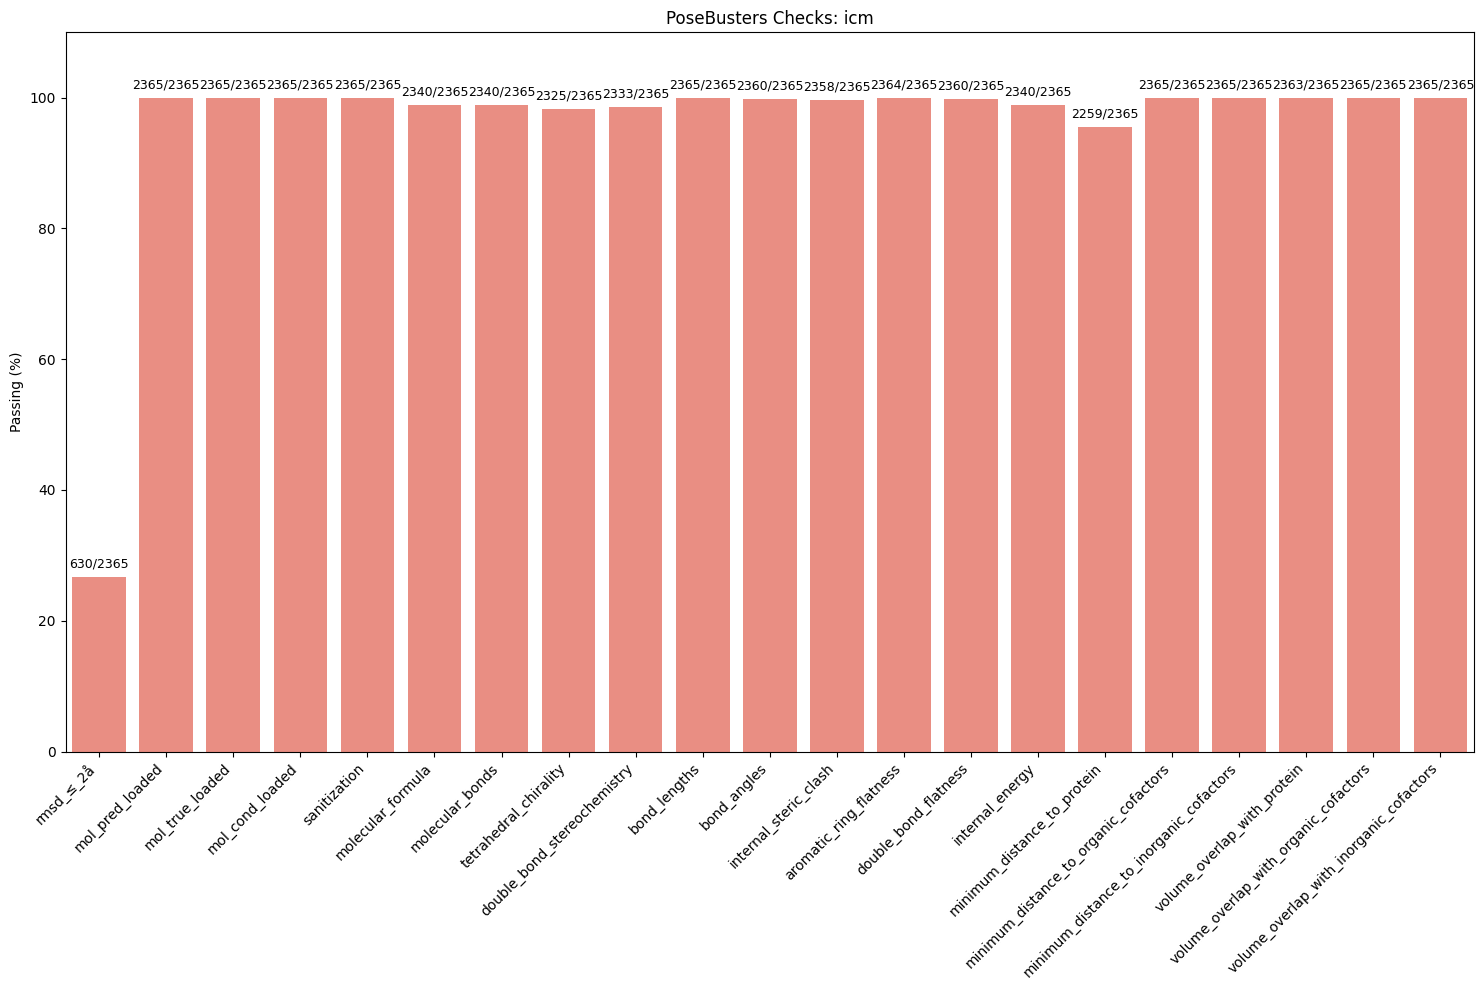

In [31]:
def plot_single_approach_posebusters(df, approach_name, test_cols=BUST_TEST_COLUMNS):
    # Count how many total conformations
    total = len(df)

    # Calculate pass proportion for each test
    results = []
    for col in test_cols:
        pass_count = df[col].sum()  # assuming booleans or 0/1
        prop = pass_count / total if total else 0.0
        results.append((col, pass_count, total, prop))

    # Convert to DataFrame
    prop_df = pd.DataFrame(results, columns=["test", "pass_count", "total", "proportion"])
    prop_df["percentage"] = 100.0 * prop_df["proportion"]

    # Sort or keep the test_cols order
    prop_df["test"] = pd.Categorical(prop_df["test"], categories=test_cols, ordered=True)
    prop_df.sort_values("test", inplace=True)

    # Plot
    plt.figure(figsize=(15, 10))
    sns.barplot(data=prop_df, x="test", y="percentage", color="salmon")
    plt.ylim(0, 110)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("Passing (%)")
    plt.title(f"PoseBusters Checks: {approach_name}")
    
    # Annotate each bar with pass_count / total
    ax = plt.gca()
    for i, row in prop_df.iterrows():
        ax.text(i, row["percentage"] + 1,
                f"{int(row['pass_count'])}/{int(row['total'])}",
                ha="center", va="bottom", fontsize=9)
        
    plt.tight_layout()
    plt.show()

plot_single_approach_posebusters(df_combined[(df_combined.method == 'icm')], approach_name="icm")

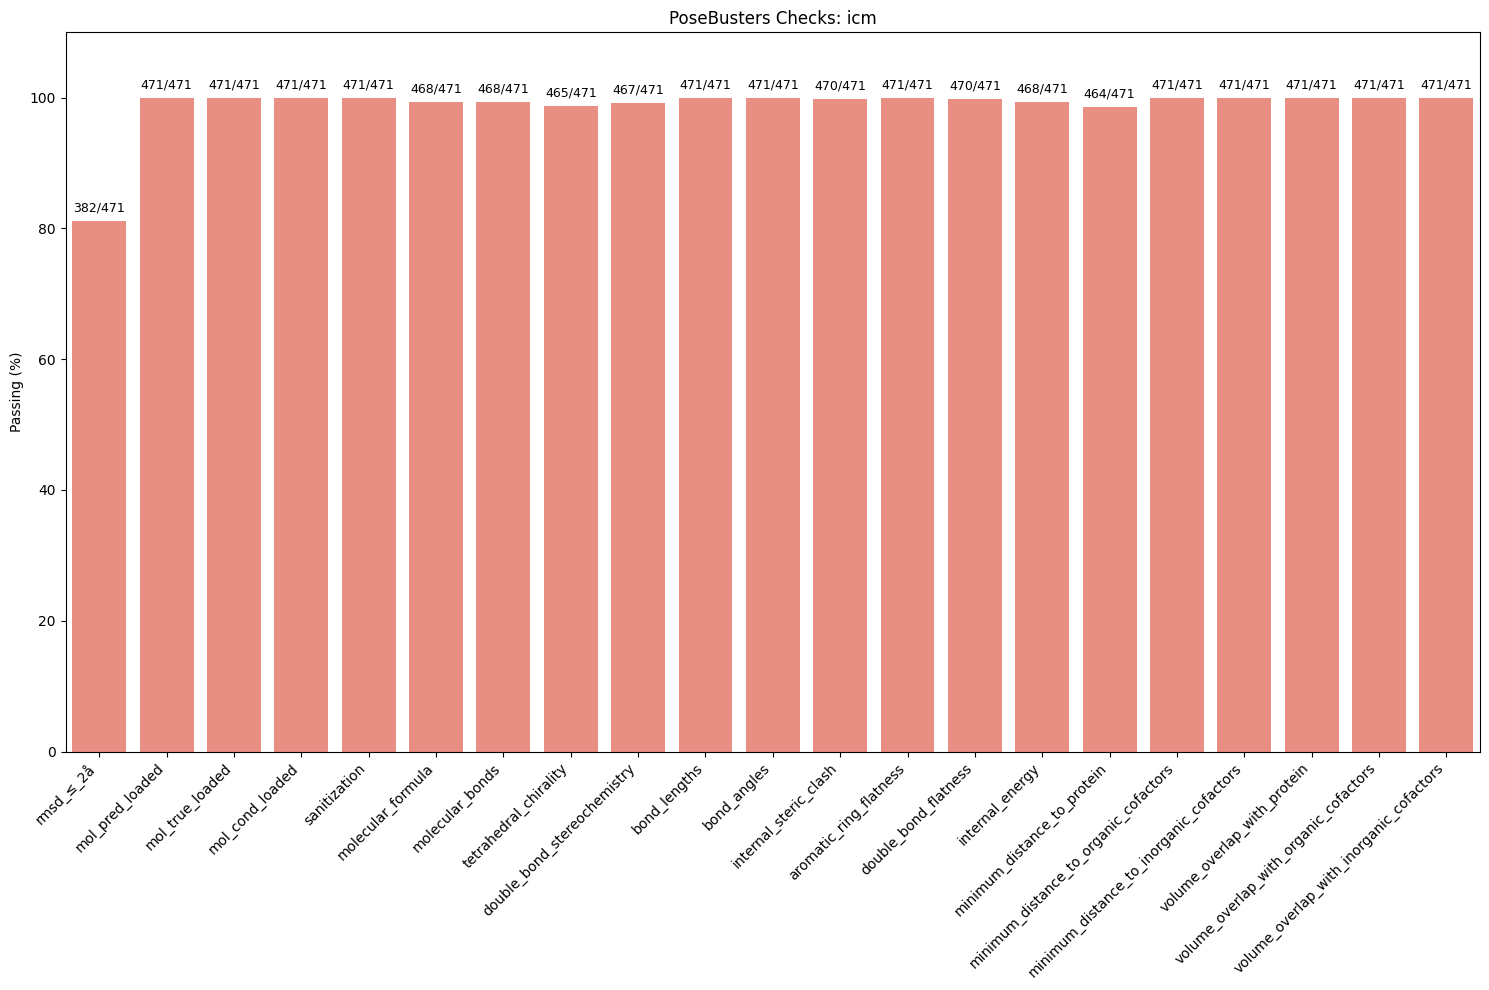

In [32]:
plot_single_approach_posebusters(df_best[(df_best.method == 'icm')], approach_name="icm")

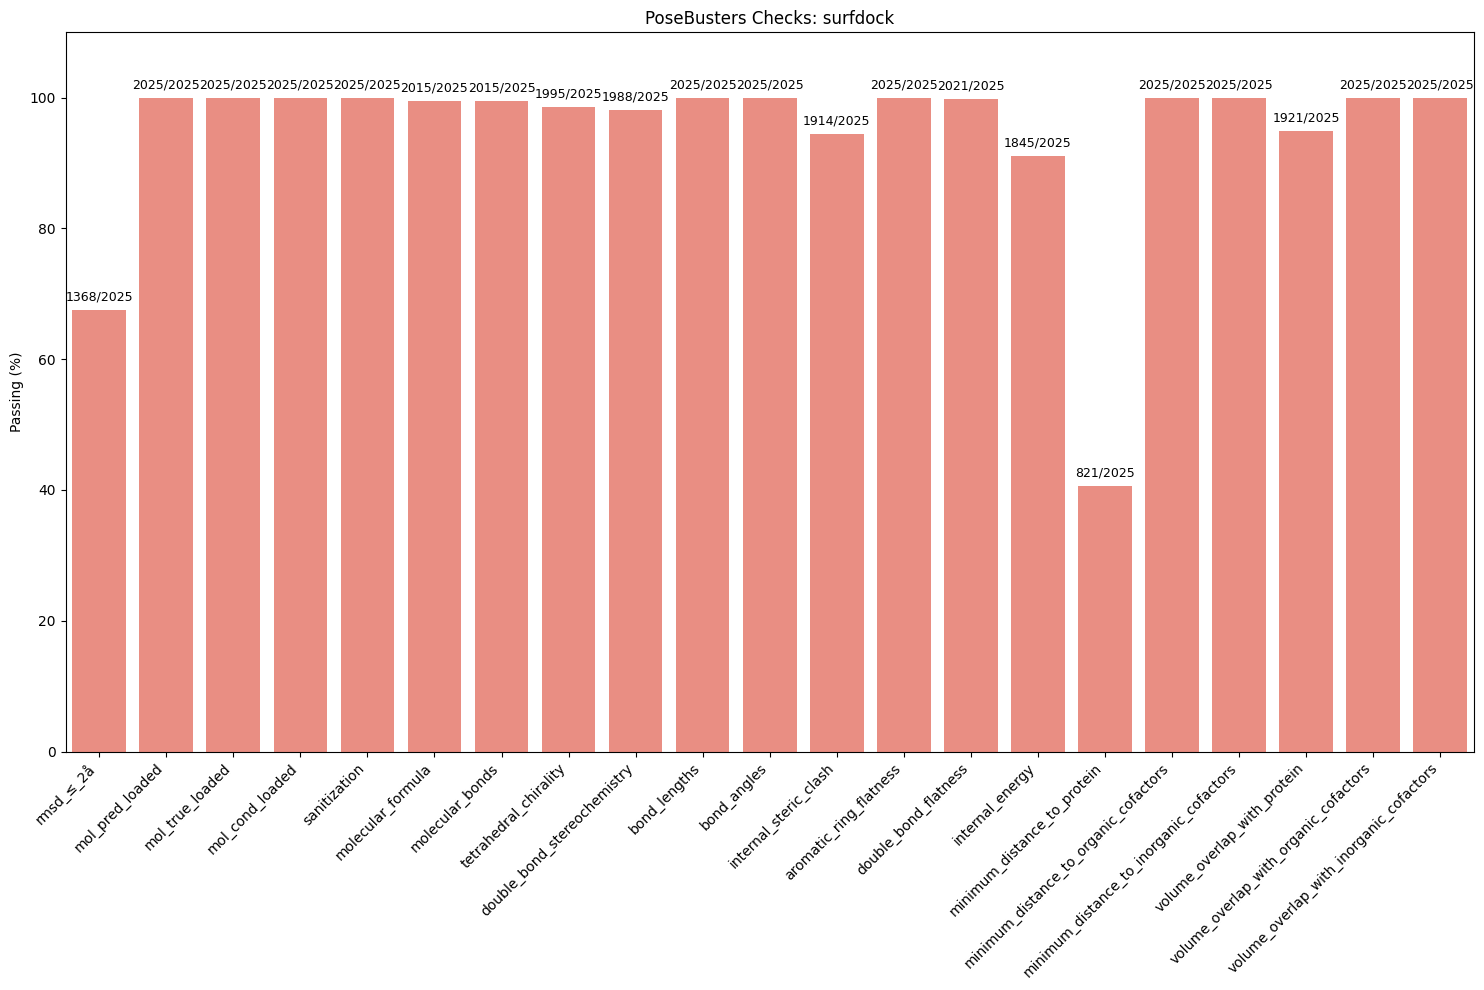

In [33]:
plot_single_approach_posebusters(df_combined[(df_combined.method == 'surfdock')], approach_name="surfdock")

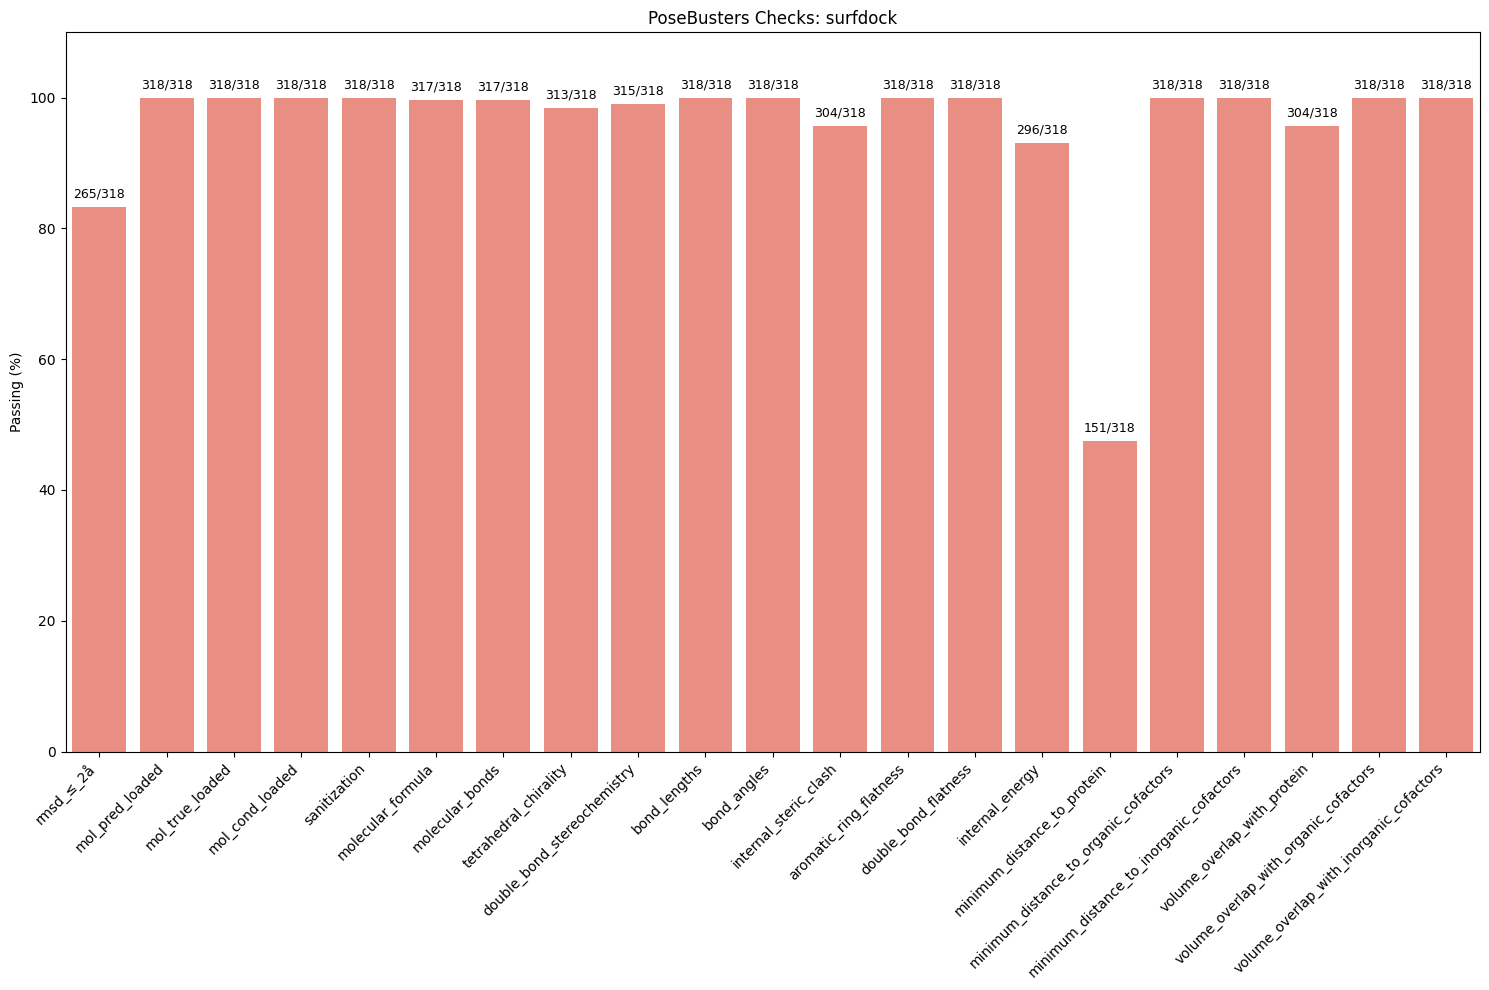

In [34]:
plot_single_approach_posebusters(df_best[(df_best.method == 'surfdock')], approach_name="surfdock")

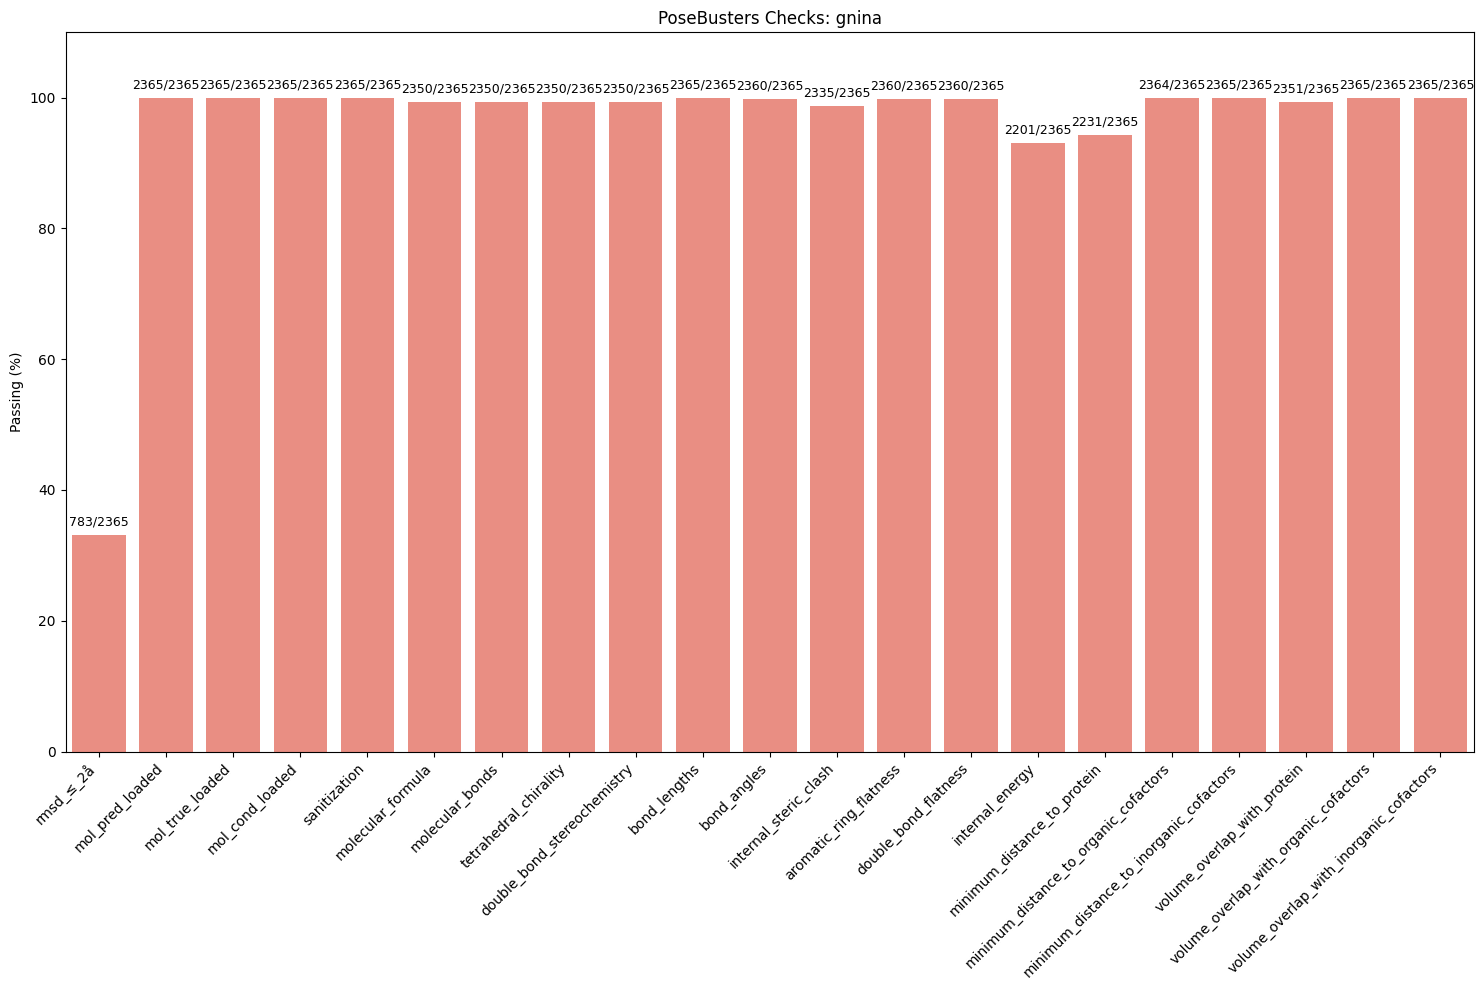

In [35]:
plot_single_approach_posebusters(df_combined[(df_combined.method == 'gnina')], approach_name="gnina")

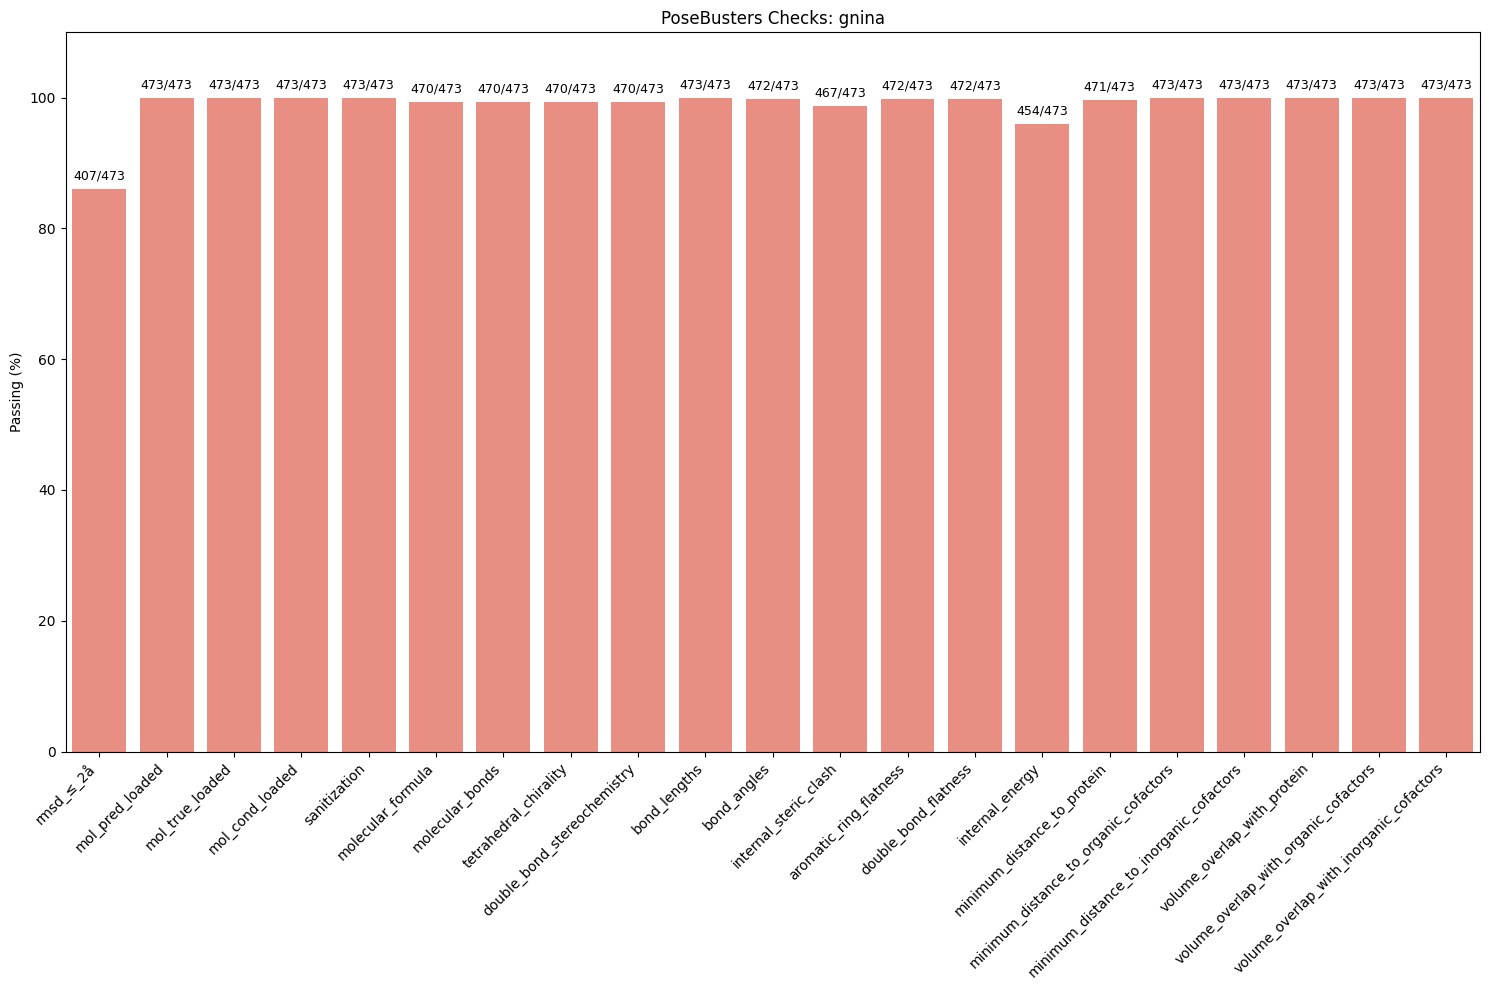

In [36]:
plot_single_approach_posebusters(df_best[(df_best.method == 'gnina')], approach_name="gnina")

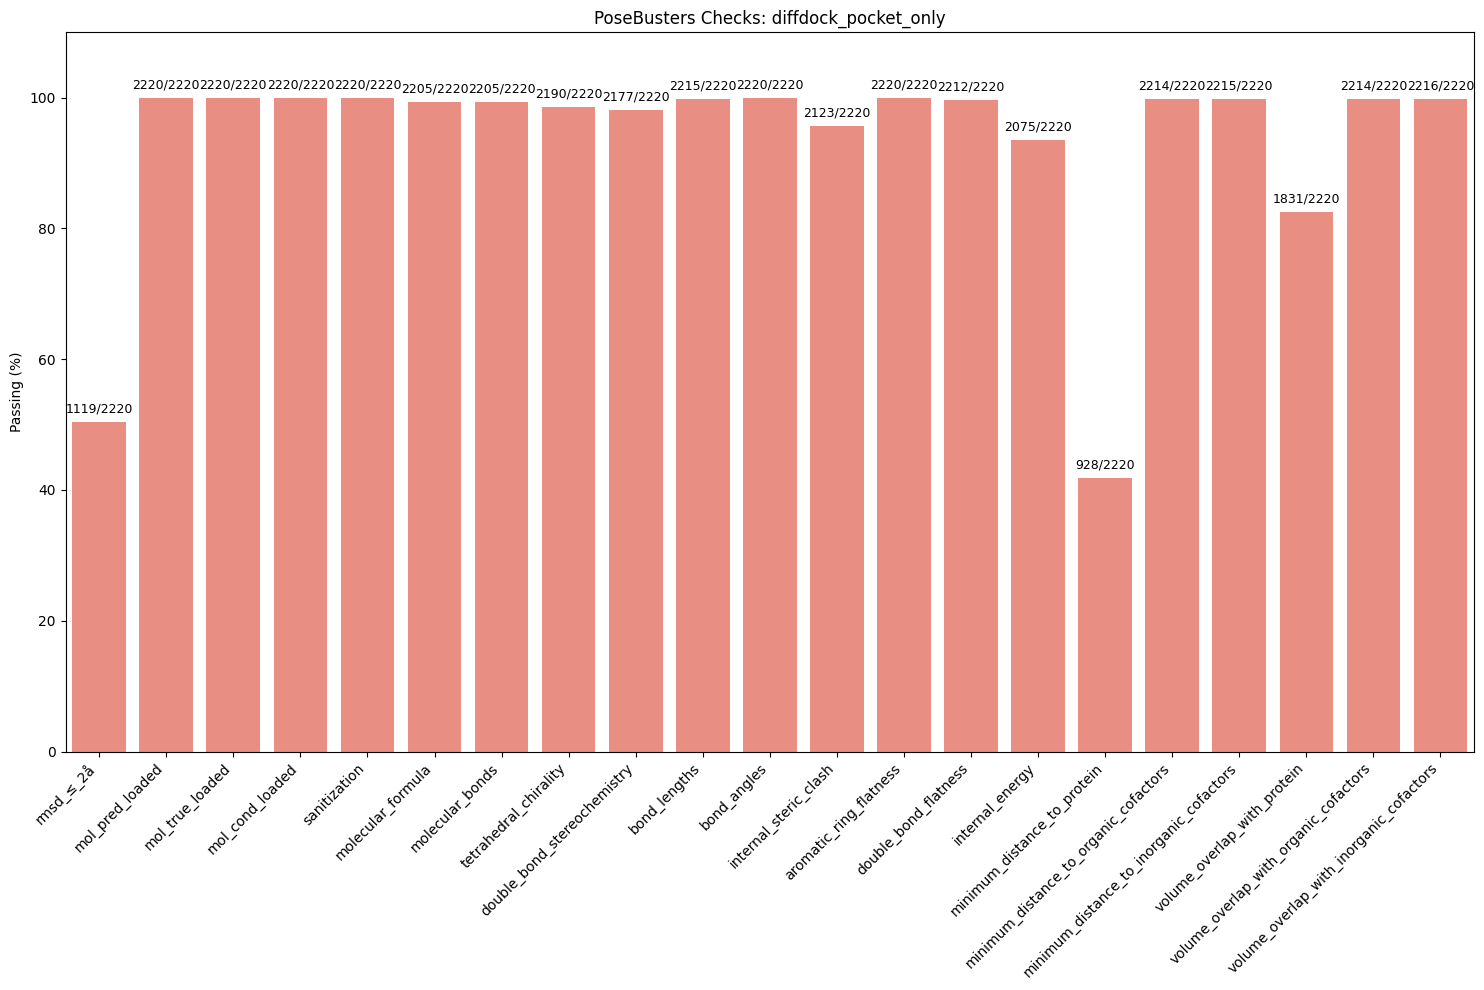

In [37]:
plot_single_approach_posebusters(df_combined[(df_combined.method == 'diffdock_pocket_only')], approach_name="diffdock_pocket_only")

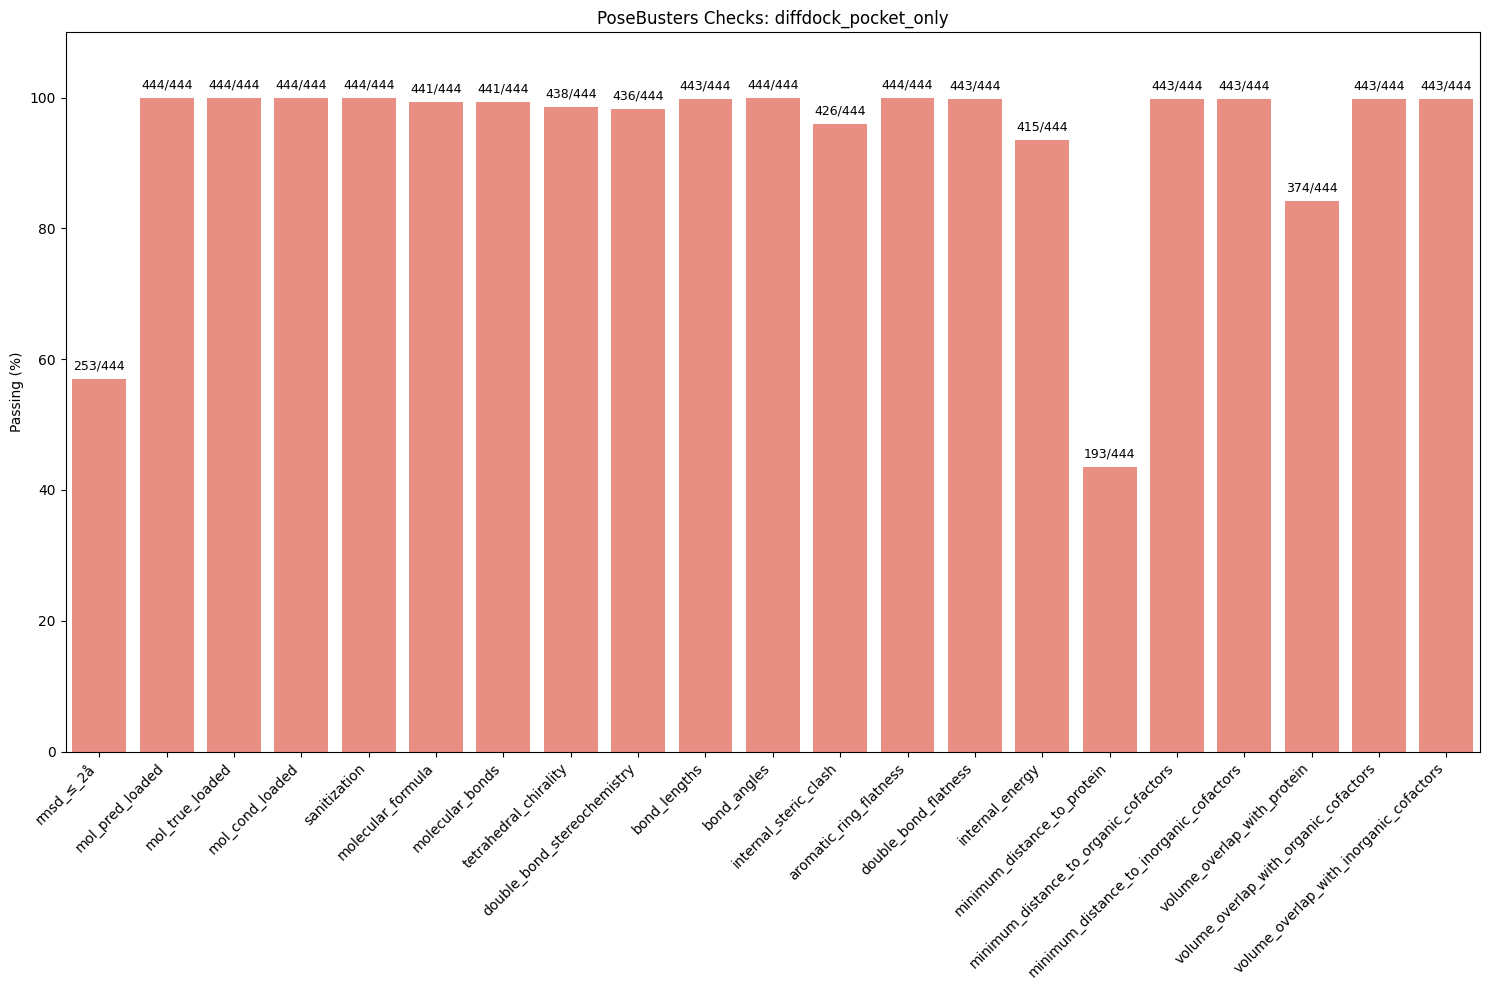

In [38]:
plot_single_approach_posebusters(df_best[(df_best.method == 'diffdock_pocket_only')], approach_name="diffdock_pocket_only")

**Q: does fail in pb validity check -> large RMSD?**

In [39]:
def split_by_boolean(df, bool_col, numeric_col):
    """
    Return two Series: x_pass, x_fail
      - x_pass: numeric_col values where bool_col == True
      - x_fail: numeric_col values where bool_col == False
    Also drops NaN for cleanliness.
    """
    x_pass = df.loc[df[bool_col] == True,  numeric_col].dropna()
    x_fail = df.loc[df[bool_col] == False, numeric_col].dropna()
    return x_pass, x_fail


def plot_boxplot_boolean_numeric(df, bool_col, numeric_col, ax=None):
    """
    Create a boxplot comparing numeric_col for pass vs. fail in bool_col.
    If ax is None, create a new figure+axes.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    
    sns.boxplot(
        data=df, 
        x=bool_col, 
        y=numeric_col, 
        ax=ax
    )
    ax.set_title(f"{numeric_col} by {bool_col}")
    ax.set_xlabel(f"{bool_col} (False/True)")
    ax.set_ylabel(numeric_col)
    
    return ax  # Return the axes for further customization if needed


from scipy.stats import mannwhitneyu, pointbiserialr

def mann_whitney_test(x_pass, x_fail):
    """
    Perform Mann-Whitney U test on two numeric arrays x_pass vs x_fail.
    Returns (stat, pvalue). If one group is empty, return (None, None).
    """
    if len(x_pass) > 0 and len(x_fail) > 0:
        stat, pval = mannwhitneyu(x_pass, x_fail, alternative="two-sided")
        return stat, pval
    return None, None

def point_biserial(df, bool_col, numeric_col):
    """
    Compute point-biserial correlation between bool_col (boolean) and numeric_col.
    Returns (corr, pval). If not enough data, returns (None, None).
    """
    # convert bool -> 0/1
    y_bool = df[bool_col].astype(int)
    x_num  = df[numeric_col]
    mask = x_num.notna()
    
    if mask.sum() < 2:
        return None, None
    
    corr, pval = pointbiserialr(y_bool[mask], x_num[mask])
    return corr, pval

In [40]:
def analyze_boolean_numeric_pair(df, bool_col, numeric_col, plot=True):
    """
    Analyze how numeric_col differs based on bool_col pass/fail.
    - Plots a boxplot if plot=True.
    - Computes Mann-Whitney and point-biserial correlation.
    Returns a dict with results.
    """
    # Split data
    x_pass, x_fail = split_by_boolean(df, bool_col, numeric_col)

    # Plot if desired
    ax = None
    if plot:
        ax = plot_boxplot_boolean_numeric(df, bool_col, numeric_col)
        plt.show()

    # Mann-Whitney
    mw_stat, mw_p = mann_whitney_test(x_pass, x_fail)

    # Point-biserial
    corr, corr_p = point_biserial(df, bool_col, numeric_col)

    # Prepare a summary
    results = {
        "bool_col": bool_col,
        "numeric_col": numeric_col,
        "mannwhitney_stat": mw_stat,
        "mannwhitney_p": mw_p,
        "pointbiserial_corr": corr,
        "pointbiserial_p": corr_p,
        "n_pass": len(x_pass),
        "n_fail": len(x_fail),
    }
    return results

In [41]:
def run_boolean_numeric_pipeline(
    df, 
    boolean_checks, 
    numeric_columns, 
    do_plots=False
):
    """
    For each bool_col in boolean_checks, and each numeric_col in numeric_columns,
    call analyze_boolean_numeric_pair, collect stats in a DataFrame.
    If do_plots=True, show the boxplots as well.
    """
    all_results = []

    for bool_col in boolean_checks:
        for numeric_col in numeric_columns:
            res = analyze_boolean_numeric_pair(
                df, bool_col, numeric_col, plot=do_plots
            )
            all_results.append(res)

    # Convert list of dicts into a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

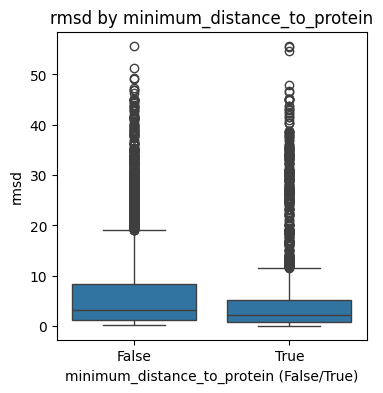

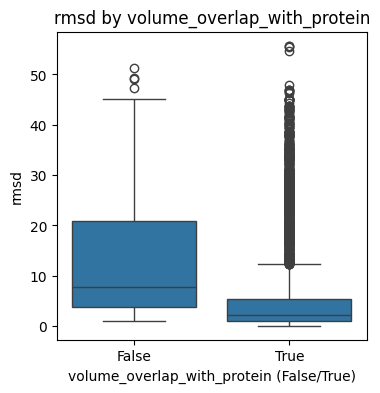

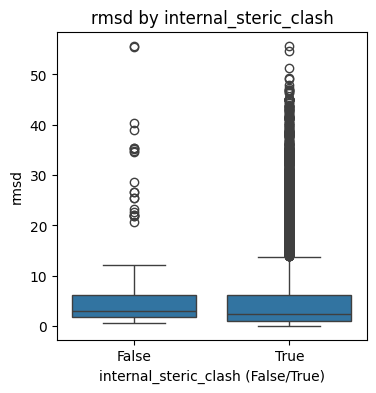

,bool_col,numeric_col,mannwhitney_stat,mannwhitney_p,pointbiserial_corr,pointbiserial_p,n_pass,n_fail
0,minimum_distance_to_protein,rmsd,15809880.0,5.797541e-87,-0.165455,2.021138e-80,8045,4951
1,volume_overlap_with_protein,rmsd,2997984.0,6.958735e-226,-0.268125,8.073834e-213,11824,1172
2,internal_steric_clash,rmsd,1705062.0,2.570254e-06,0.003122,7.219659e-01,12678,318


In [42]:
results_df = run_boolean_numeric_pipeline(
    df_combined,
    ["minimum_distance_to_protein", "volume_overlap_with_protein", "internal_steric_clash"],
    ["rmsd"],
    do_plots=True
)
results_df

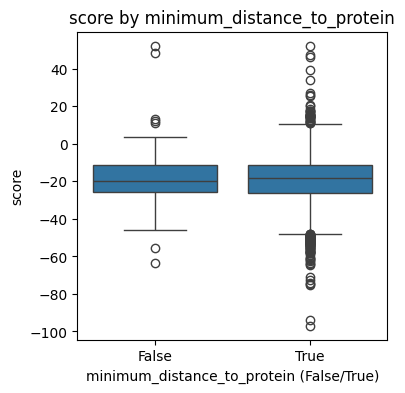

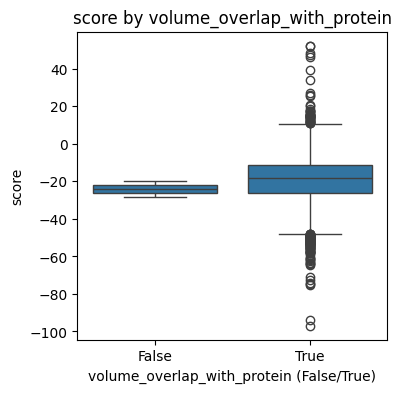

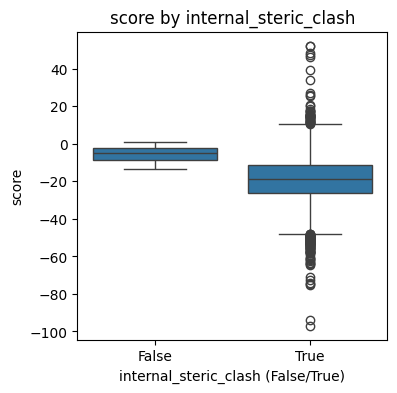

,bool_col,numeric_col,mannwhitney_stat,mannwhitney_p,pointbiserial_corr,pointbiserial_p,n_pass,n_fail
0,minimum_distance_to_protein,score,120941.0,0.859816,-0.022073,0.283274,2259,106
1,volume_overlap_with_protein,score,3171.0,0.433609,0.009287,0.651707,2363,2
2,internal_steric_clash,score,2307.0,0.000352,-0.053282,0.009552,2358,7


In [43]:
run_boolean_numeric_pipeline(
    df_combined[df_combined['method'] == 'icm'],
    ["minimum_distance_to_protein", "volume_overlap_with_protein", "internal_steric_clash"],
    ["score"],
    do_plots=True
)

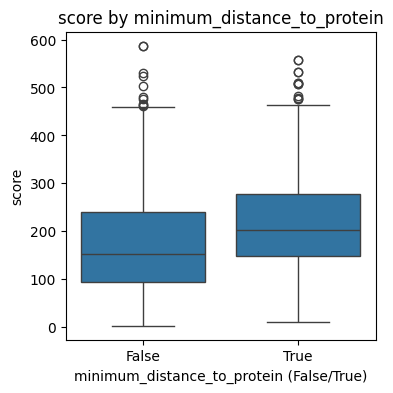

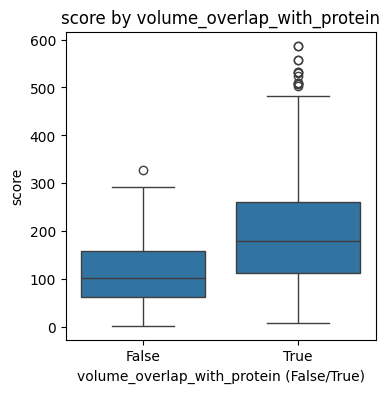

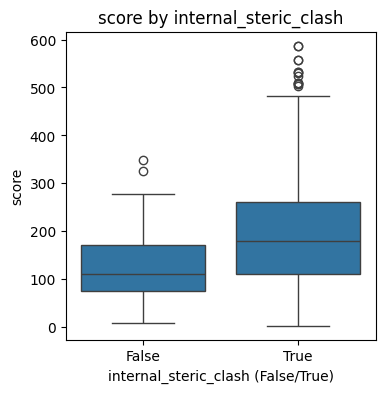

,bool_col,numeric_col,mannwhitney_stat,mannwhitney_p,pointbiserial_corr,pointbiserial_p,n_pass,n_fail
0,minimum_distance_to_protein,score,620460.0,1.510773e-22,0.195601,6.534122e-19,821,1204
1,volume_overlap_with_protein,score,143941.0,3.340061e-14,0.163404,1.378148e-13,1921,104
2,internal_steric_clash,score,145760.0,4.091035e-11,0.140697,2.029545e-10,1914,111


In [44]:
run_boolean_numeric_pipeline(
    df_combined[df_combined['method'] == 'surfdock'],
    ["minimum_distance_to_protein", "volume_overlap_with_protein", "internal_steric_clash"],
    ["score"],
    do_plots=True
)

Index(['mol_pred_loaded', 'mol_true_loaded', 'mol_cond_loaded', 'sanitization', 'all_atoms_connected', 'molecular_formula', 'molecular_bonds', 'double_bond_stereochemistry', 'tetrahedral_chirality', 'bond_lengths',
       ...
       'mol', 'fp', 'has_ion', 'rmsd_≤_1å', 'rmsd_≤_5å', 'success', 'success_1å', 'success_2å', 'success_5å', 'normalized_score'], dtype='object', length=161)


<Axes: xlabel='minimum_distance_to_protein', ylabel='rmsd'>

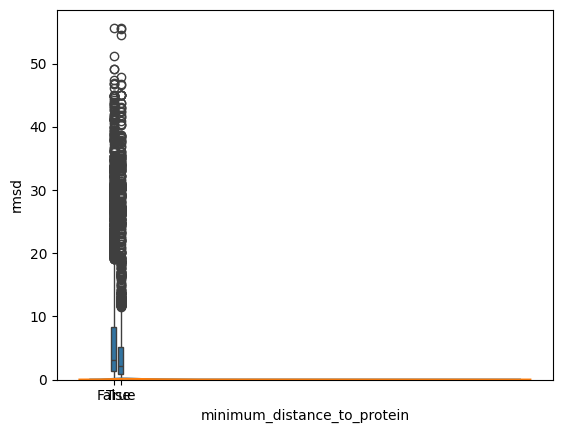

In [45]:
pass_mask = df_combined_no_na["minimum_distance_to_protein"]  # True/False
fail_mask = ~pass_mask
#### Visual analysis
print(df_combined.columns)
sns.boxplot(data=df_combined, x="minimum_distance_to_protein", y="rmsd")
sns.kdeplot(data=df_combined_no_na[pass_mask], x="rmsd", label="Pass")
sns.kdeplot(data=df_combined_no_na[fail_mask], x="rmsd", label="Fail")

#### Statistical Analysi

In [ ]:
from scipy.stats import pointbiserialr

fail_boolean = df_best["minimum_distance_to_protein"].astype(int)  # 1=pass, 0=fail (or vice versa)
rmsd_vals = df_best["rmsd"]
corr, pval = pointbiserialr(fail_boolean, rmsd_vals)
print("Point-biserial correlation:", corr, "p-value:", pval)

### Regression Analysi

In [ ]:
numeric_cols = ["rmsd", "score", "some_other_metric"]
corr_matrix = df_all[numeric_cols].corr()
print(corr_matrix)

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Per-protein Analysis

**Success rate per protein**
Use this to  see which proteins are “easy” or “hard” for each metho

In [ ]:
per_protein_method = df_combined.groupby(["protein","method"])["rmsd_≤_2å"].mean().reset_index()
per_protein_method.head()

In [ ]:
success_pivot = per_protein_method.pivot(
    index="protein", 
    columns="method", 
    values="rmsd_≤_2å"
)
success_pivot.head()

**2. Minimum RMSD among top-N poses:**  compute the minimum RMSD per (protein, method) to see the best that method can do for each protein:

In [ ]:
best_rmsd = df_combined.groupby(["protein","method"])["rmsd"].min().reset_index()
best_rmsd_pivot = best_rmsd.pivot(index="protein", columns="method", values="rmsd")
best_rmsd_pivot.head()

## Pairwise or overlap analysis

**1. Which proteins are solved by multiple methods**

In [ ]:
df_combined["success"] = df_combined["rmsd_≤_2å"]

In [ ]:
# For each protein, count how many methods succeeded
success_counts = (
    df_combined[df_combined["success"] == True]
    .groupby(["protein","method"])["success"]
    .first()  # or .any(), if multiple rows
    .unstack(fill_value=False)
)
success_counts.head()

#### Complementary Analysis

In [ ]:
import itertools

# Suppose success_counts is a DataFrame with boolean columns for each method
# Example columns: ["icm", "diffdock", "chai-1", "diffdock_pocket_only", "surfdock"]

methods = success_counts.columns.tolist()  # or list them explicitly if you want a specific subset
pairs = list(itertools.combinations(methods, 2))

# Dictionary to store pairwise overlaps
overlap_dict = {}

for (m1, m2) in pairs:
    # Count how many entries are True for BOTH methods
    overlap_count = success_counts[[m1, m2]].all(axis=1).sum()
    overlap_dict[(m1, m2)] = overlap_count

# Convert the dictionary into a DataFrame for better readability
overlap_df = pd.DataFrame.from_dict(overlap_dict, orient='index', columns=['Overlap_Count'])

# Optionally sort by overlap count (descending)
overlap_df = overlap_df.sort_values(by='Overlap_Count', ascending=False)

print(overlap_df)

In [ ]:
success_counts
methods = success_counts.columns.tolist()
pairwise_df = pd.DataFrame(
    0, index=methods, columns=methods, 
    dtype="Int64"  # or int if you prefer
)

for m1 in methods:
    for m2 in methods:
        if m1 == m2:
            # Some people prefer to leave diagonal empty or None
            pairwise_df.loc[m1, m2] = pd.NA
        else:
            # Count proteins that method m1 succeeded but m2 did not
            mask = success_counts[m1] & (~success_counts[m2])
            pairwise_df.loc[m1, m2] = mask.sum()

pairwise_df

#### figure out the protein name for specail cases

In [ ]:
def get_complementary_proteins(success_counts, method_i, method_j):
    """
    Get proteins where method_i succeeds and method_j fails.
    """
    mask = success_counts[method_i] & (~success_counts[method_j])
    complementary_proteins = success_counts[mask].index.tolist()
    return complementary_proteins

# Example usage for methods 'icm' and 'diffdock'
method_i = 'diffdock_pocket_only'
method_j = 'icm'
complementary_proteins = get_complementary_proteins(success_counts, method_i, method_j)
print(f"Proteins where {method_i} succeeds and {method_j} fails: {complementary_proteins}")

method_i, method_j = "chai-1", "icm"
complementary_proteins  = get_complementary_proteins(success_counts, 'chai-1', 'icm')
print(f"Proteins where {method_i} succeeds and {method_j} fails: {complementary_proteins}")

method_i, method_j = 'icm', 'diffdock_pocket_only'
complementary_proteins  = get_complementary_proteins(success_counts, f'{method_i}', f'{method_j}')
print(f"Proteins where {method_i} succeeds and {method_j}m fails: {complementary_proteins}")


In [ ]:
print(f"Proteins where {method_i} succeeds and {method_j} fails: {complementary_proteins}")
# List of methods to check for consistent failure
methods_to_check = ['icm', 'gnina']

# Find proteins that failed for all specified methods
consistent_failures = success_counts[methods_to_check].any(axis=1) == False
failed_proteins = success_counts[consistent_failures].index.tolist()

print(f"Proteins that consistently failed for methods {methods_to_check}: {failed_proteins}")

In [ ]:
method_i = "icm"
method_j = "gnina"
mask_i = (~success_counts[method_i])
mask_j = (~success_counts[method_j])
fail_i = success_counts[mask_i].index.tolist()
fail_j = success_counts[mask_j].index.tolist()
print(f"Proteins that failed for {method_i}: {fail_i}")
print(f"Proteins that failed for {method_j}: {fail_j}")
intersection = set(fail_i).intersection(fail_j)
print(f"Proteins that failed for both {method_i} and {method_j}: {intersection}")

def get_all_failure_proteins(success_counts, methods):
    """
    Get proteins that failed for all specified methods.
    Returns a list of protein names.
    """
    if not methods:
        return []
        
    # Get proteins that failed for the first method
    method = methods[0]
    mask = (~success_counts[method])
    all_failure_set = set(success_counts[mask].index.tolist())
    
    # Intersect with failures from other methods
    for method in methods[1:]:
        mask = (~success_counts[method])
        fail_proteins = set(success_counts[mask].index.tolist())
        all_failure_set = all_failure_set.intersection(fail_proteins)
        
    return list(all_failure_set)

# Usage example:
failures = get_all_failure_proteins(success_counts, ['diffdock', 'diffdock_pocket_only'])
print(f"Proteins that failed for all methods {['diffdock', 'chai-1']}: {failures}")

In [ ]:
method_i = "icm"
method_j = "gnina"
mask_i = (~success_counts[method_i])
mask_j = (~success_counts[method_j])
fail_i = success_counts[mask_i].index.tolist()
fail_j = success_counts[mask_j].index.tolist()
print(f"Proteins that failed for {method_i}: {fail_i}")
print(f"Proteins that failed for {method_j}: {fail_j}")
intersection = set(fail_i).intersection(fail_j)
print(f"Proteins that failed for both {method_i} and {method_j}: {intersection}")

def get_all_failure_proteins(success_counts, methods):
    """
    Get proteins that failed for all specified methods.
    Returns a list of protein names.
    """
    if not methods:
        return []
        
    # Get proteins that failed for the first method
    method = methods[0]
    mask = (~success_counts[method])
    all_failure_set = set(success_counts[mask].index.tolist())
    
    # Intersect with failures from other methods
    for method in methods[1:]:
        mask = (~success_counts[method])
        fail_proteins = set(success_counts[mask].index.tolist())
        all_failure_set = all_failure_set.intersection(fail_proteins)
        
    return list(all_failure_set)

# Usage example:
failures = get_all_failure_proteins(success_counts, ['diffdock', 'diffdock_pocket_only'])
print(f"Proteins that failed for all methods {['diffdock', 'chai-1']}: {failures}")

In [ ]:
method_i = "icm"
method_j = "gnina"
mask_i = (~success_counts[method_i])
mask_j = (~success_counts[method_j])
fail_i = success_counts[mask_i].index.tolist()
fail_j = success_counts[mask_j].index.tolist()
print(f"Proteins that failed for {method_i}: {fail_i}")
print(f"Proteins that failed for {method_j}: {fail_j}")
intersection = set(fail_i).intersection(fail_j)
print(f"Proteins that failed for both {method_i} and {method_j}: {intersection}")

def get_all_failure_proteins(success_counts, methods):
    """
    Get proteins that failed for all specified methods.
    Returns a list of protein names.
    """
    if not methods:
        return []
        
    # Get proteins that failed for the first method
    method = methods[0]
    mask = (~success_counts[method])
    all_failure_set = set(success_counts[mask].index.tolist())
    
    # Intersect with failures from other methods
    for method in methods[1:]:
        mask = (~success_counts[method])
        fail_proteins = set(success_counts[mask].index.tolist())
        all_failure_set = all_failure_set.intersection(fail_proteins)
        
    return list(all_failure_set)

# Usage example:
failures = get_all_failure_proteins(success_counts, ['diffdock', 'diffdock_pocket_only'])
print(f"Proteins that failed for all methods {['diffdock', 'chai-1']}: {failures}")

In [ ]:
method_i = "icm"
method_j = "gnina"
mask_i = (~success_counts[method_i])
mask_j = (~success_counts[method_j])
fail_i = success_counts[mask_i].index.tolist()
fail_j = success_counts[mask_j].index.tolist()
print(f"Proteins that failed for {method_i}: {fail_i}")
print(f"Proteins that failed for {method_j}: {fail_j}")
intersection = set(fail_i).intersection(fail_j)
print(f"Proteins that failed for both {method_i} and {method_j}: {intersection}")

def get_all_failure_proteins(success_counts, methods):
    """
    Get proteins that failed for all specified methods.
    Returns a list of protein names.
    """
    if not methods:
        return []
        
    # Get proteins that failed for the first method
    method = methods[0]
    mask = (~success_counts[method])
    all_failure_set = set(success_counts[mask].index.tolist())
    
    # Intersect with failures from other methods
    for method in methods[1:]:
        mask = (~success_counts[method])
        fail_proteins = set(success_counts[mask].index.tolist())
        all_failure_set = all_failure_set.intersection(fail_proteins)
        
    return list(all_failure_set)

# Usage example:
failures = get_all_failure_proteins(success_counts, ['diffdock', 'diffdock_pocket_only'])
print(f"Proteins that failed for all methods {['diffdock', 'chai-1']}: {failures}")

In [ ]:
from upsetplot import from_contents, UpSet

# 2) Make sets of proteins for each method
df_solved = success_counts.copy()
methods = ["icm", "diffdock", "gnina", "vina", "surfdock", "diffdock_pocket_only"]
method_sets = {}

for method in methods:
    mask = (success_counts[method])
    method_sets[method] = set( success_counts[mask].index.tolist())

# 3) Convert to an upsetplot-compatible structure
upset_data = from_contents(method_sets)

# 4) Create the UpSet figure
UpSet(upset_data, show_counts=True, subset_size='count', sort_categories_by=None).plot()
plt.suptitle("Overlap of Proteins Solved by Different Methods")
plt.show()

# Synergy example:
# Suppose you want to see proteins that exactly 'icm_solved' or 'diffdock_solved' but not the others:
# You can check the UpSet intersection or do a quick filter in the data:
df_solved["icm_or_diffdock"] = df_solved["icm"] | df_solved["diffdock"]
df_solved["others_solved"] = df_solved["gnina"] | df_solved["vina"] | df_solved["surfdock"]
synergy_df = df_solved[ (df_solved["icm_or_diffdock"]) & (~df_solved["others_solved"]) ]
print("Proteins solved by (ICM or DiffDock) but NOT by others:\n", synergy_df["protein"].tolist())

In [ ]:
from upsetplot import from_indicators
# Example: we have booleans for 5 methods
# methods = ["icm", "diffdock", "gnina", "surfdock", "vina"]

# 1) For each row (protein), count how many methods = True
df_solved["num_methods"] = df_solved[methods].sum(axis=1)

# 2) Filter to keep only rows with up to 2 methods = True
df_filtered = df_solved[df_solved["num_methods"] <= 2].copy()

# 3) Build an UpSet-friendly structure. 
#    One easy way is from_indicators: for each method col, it must be boolean 
#    for "icm" or "diffdock", etc.
upset_data = from_indicators(methods, data=df_filtered[methods])

# 4) Create and plot the UpSet
UpSet(
    upset_data, 
    show_counts=True, 
    subset_size='count', 
    sort_categories_by=None
).plot()

plt.suptitle("UpSet: Intersection of at most 2 methods")
plt.show()

### In-depth analysis for failed cases for ICM

In [ ]:
failed_proteins = success_counts[success_counts['icm'] == False].index.tolist()
print(f"Proteins where ICM failed: {failed_proteins}")

# Optional: See full details for these proteins
icm_failures = df_combined[
    (df_combined['protein'].isin(failed_proteins)) & 
    (df_combined['method'] == 'icm')
]
# display(icm_failures)
print(len(icm_failures))

In [ ]:
# 1. Get ICM failed proteins
icm_failed = success_counts[success_counts['icm'] == False].index

# 2. Create comparison table for failed proteins
failure_comparison = success_counts.loc[icm_failed]

# 3. Display results
print("Success/Failure patterns for ICM-failed proteins:")
display(failure_comparison)

### plot_rmsd_comparisons

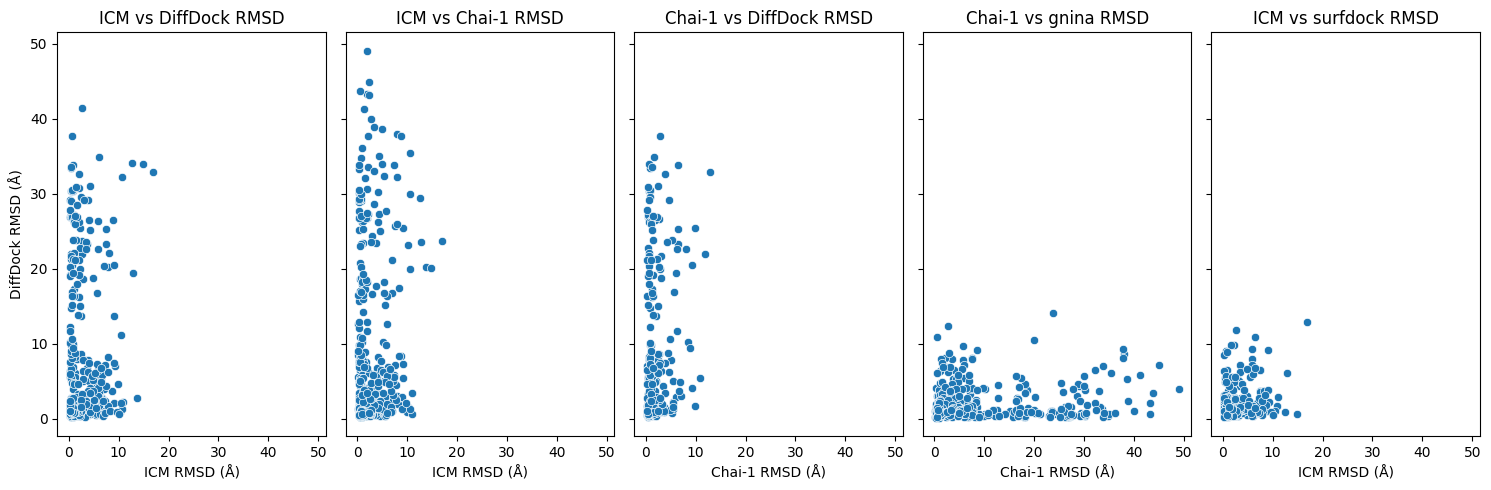

In [59]:
# Create subplots for all three comparisons
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)

# ICM vs DiffDock
sns.scatterplot(data=pivot_df, x='icm', y='diffdock_pocket_only', ax=ax1)
ax1.set_xlabel('ICM RMSD (Å)')
ax1.set_ylabel('DiffDock RMSD (Å)')
ax1.set_title('ICM vs DiffDock RMSD')

# ICM vs Chai-1
sns.scatterplot(data=pivot_df, x='icm', y='chai-1', ax=ax2)
ax2.set_xlabel('ICM RMSD (Å)')
ax2.set_ylabel('Chai-1 RMSD (Å)')
ax2.set_title('ICM vs Chai-1 RMSD')

# Chai-1 vs DiffDock
sns.scatterplot(data=pivot_df, x='surfdock', y='diffdock_pocket_only', ax=ax3)
ax3.set_xlabel('Chai-1 RMSD (Å)')
ax3.set_ylabel('DiffDock RMSD (Å)')
ax3.set_title('Chai-1 vs DiffDock RMSD')

# Diffdock vs gnina
sns.scatterplot(data=pivot_df, x='chai-1', y='gnina', ax=ax4)
ax4.set_xlabel('Chai-1 RMSD (Å)')
ax4.set_ylabel('gnina RMSD (Å)')
ax4.set_title('Chai-1 vs gnina RMSD')

# chai-1 vs surfdock
sns.scatterplot(data=pivot_df, x='icm', y='surfdock', ax=ax5)
ax5.set_xlabel('ICM RMSD (Å)')
ax5.set_ylabel('surfdock RMSD (Å)')
ax5.set_title('ICM vs surfdock RMSD')

plt.tight_layout()
plt.show()

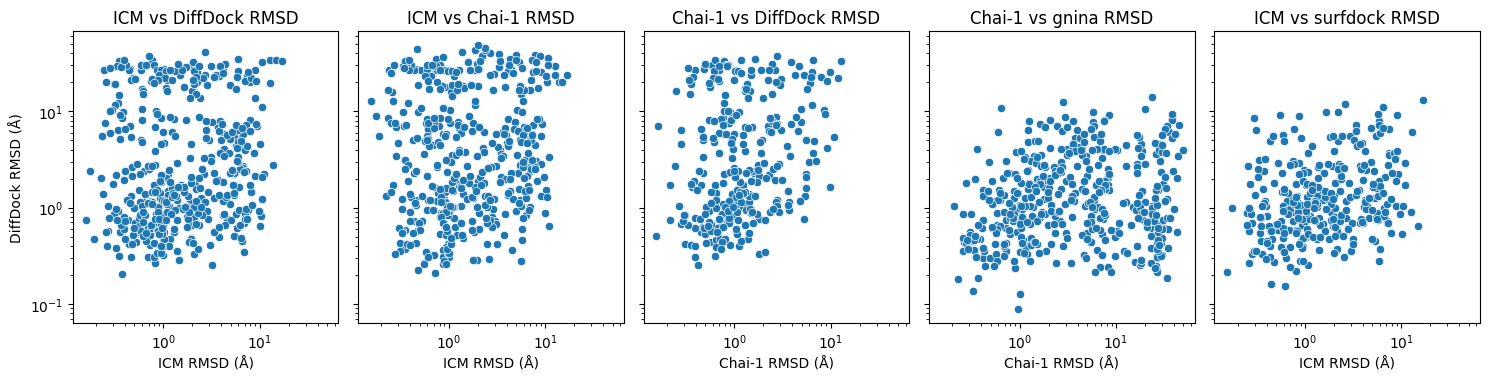

In [60]:
# Create subplots for all three comparisons
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)

# ICM vs DiffDock
sns.scatterplot(data=pivot_df, x='icm', y='diffdock_pocket_only', ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('ICM RMSD (Å)')
ax1.set_ylabel('DiffDock RMSD (Å)')
ax1.set_title('ICM vs DiffDock RMSD')

# ICM vs Chai-1
sns.scatterplot(data=pivot_df, x='icm', y='chai-1', ax=ax2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('ICM RMSD (Å)')
ax2.set_ylabel('Chai-1 RMSD (Å)')
ax2.set_title('ICM vs Chai-1 RMSD')

# Chai-1 vs DiffDock
sns.scatterplot(data=pivot_df, x='surfdock', y='diffdock_pocket_only', ax=ax3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Chai-1 RMSD (Å)')
ax3.set_ylabel('Diffdock_pocket_only RMSD (Å)')
ax3.set_title('Chai-1 vs DiffDock RMSD')

# Diffdock vs gnina
sns.scatterplot(data=pivot_df, x='chai-1', y='gnina', ax=ax4)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Chai-1 RMSD (Å)')
ax4.set_ylabel('gnina RMSD (Å)')
ax4.set_title('Chai-1 vs gnina RMSD')

# chai-1 vs surfdock
sns.scatterplot(data=pivot_df, x='icm', y='surfdock', ax=ax5)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('ICM RMSD (Å)')
ax5.set_ylabel('surfdock RMSD (Å)')
ax5.set_title('ICM vs surfdock RMSD')

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_aspect('equal', 'box')  # or 'datalim', see below
    
plt.tight_layout()
plt.show()


In [61]:
fig = px.scatter(
    pivot_df,
    x="icm",
    y="diffdock_pocket_only",
    hover_name=pivot_df.index
)
fig.update_traces(marker=dict(size=12, opacity=0.8))

# Make both axes use the same scale:
fig.update_yaxes(scaleanchor="x", scaleratio=1)

fig.show()

In [62]:
fig = px.scatter(
    pivot_df,
    x="surfdock",
    y="diffdock_pocket_only",
    hover_name=pivot_df.index
)
fig.show()

In [63]:
fig = px.scatter(
    pivot_df,
    x="icm",
    y="surfdock",
    hover_name=pivot_df.index
)
fig.show()

## 6. Model-Fitting or Statistical Analysis

# Plinder comparative analysis